# Linescale 3 Automatic Max/Graph Maker

The purpose of this script is to take the many csv files that the linescale has from recording a specific session, add them to one big table from the day (with timestamps), find the min/max of each, and graph all of them.

One current drawback is that all the files in the single DF must be the same HZ. Will update with a solution.

## 1) Importing the Data and Assigning to an Array

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from os import listdir
from os.path import isfile, join
import os
import time
import xlwt
from xlwt.Workbook import *
from pandas import ExcelWriter
import xlsxwriter

%matplotlib inline

In [2]:
# Make list of all filenames in directory

filenames = [f for f in listdir("/Users/refuc/Linescale 3 Automation/12_4_21 Lost City") # Change directory to match where the files are located
             if isfile(join("/Users/refuc/Linescale 3 Automation/12_4_21 Lost City", f))]

# For Mac users
# filenames.remove('.DS_Store')

# Make dataframe from list
timestamp_files = pd.DataFrame(filenames)

# Show Header
timestamp_files.head()

0
0  09_46_14.CSV
1  09_49_39.CSV
2  09_52_46.CSV
3  11_15_56.CSV
4  11_54_40.CSV

In [3]:
# Make master dataframe with all measurements

df = pd.read_csv(filenames[0])
for i in range(len(filenames)-2):
    i += 1
    df2 = pd.read_csv(filenames[i])
    df = pd.concat([df, df2], axis=1)

df.head(10)

No.7          No.8          No.9          No.10         No.11  \
0      05.12.21      05.12.21      05.12.21       05.12.21      05.12.21   
1      09:46:14       9:49:39       9:52:46       11:15:56      11:54:40   
2    Speed=40Hz    Speed=40Hz    Speed=40Hz     Speed=10Hz    Speed=10Hz   
3   Trig=6.50kN   Trig=6.50kN   Trig=6.50kN    Trig=6.00kN   Trig=6.00kN   
4   Stop=0.00kN   Stop=0.00kN   Stop=0.00kN    Stop=0.00kN   Stop=0.00kN   
5     Pre=15sec     Pre=15sec     Pre=15sec     Pre=120sec    Pre=120sec   
6  Catch=120sec  Catch=120sec  Catch=120sec  Catch=1920sec  Catch=777sec   
7  Total=135sec  Total=135sec  Total=135sec  Total=2040sec  Total=897sec   
8          5.06          5.53          5.97           5.25          5.08   
9          5.05          5.53          5.96           5.26          5.07   

          No.12         No.13         No.14         No.15         No.16  ...  \
0      05.12.21      05.12.21      05.12.21      05.12.21      05.12.21  ...   
1      12:17:57      12:20:44      12:23:45      12:27:13      12:31:38  ...   
2    Speed=40Hz    Speed=40Hz    Speed=40Hz    Speed=40Hz    Speed=40Hz  ...   
3   Trig=6.00kN   Trig=6.00kN   Trig=6.00kN   Trig=6.00kN   Trig=6.00kN  ...   
4   Stop=0.00kN   Stop=0.00kN   Stop=0.00kN   Stop=0.00kN   Stop=0.00kN  ...   
5     Pre=15sec     Pre=15sec     Pre=15sec     Pre=15sec     Pre=15sec  ...   
6  Catch=120sec  Catch=120sec  Catch=120sec  Catch=120sec  Catch=120sec  ...   
7  Total=135sec  Total=135sec  Total=135sec  Total=135sec  Total=135sec  ...   
8          3.95          4.50          5.02          5.16          5.46  ...   
9          3.94          4.50          4.99          5.18          5.54  ...   

          No.32         No.33         No.34         No.35          No.1  \
0      05.12.21      05.12.21      05.12.21      05.12.21      04.12.21   
1      13:12:08      13:14:39      13:16:57      13:49:24      16:29:55   
2    Speed=40Hz    Speed=40Hz    Speed=40Hz    Speed=40Hz    Speed=40Hz   
3   Trig=6.00kN   Trig=6.00kN   Trig=6.00kN   Trig=6.00kN   Trig=5.00kN   
4   Stop=0.00kN   Stop=0.00kN   Stop=0.00kN   Stop=0.00kN   Stop=0.00kN   
5     Pre=15sec     Pre=15sec     Pre=15sec     Pre=15sec     Pre=15sec   
6  Catch=120sec  Catch=120sec  Catch=120sec  Catch=120sec  Catch=120sec   
7  Total=135sec  Total=135sec  Total=135sec  Total=135sec  Total=135sec   
8          4.98          4.58          4.53          4.87          4.81   
9          4.96          4.60          4.52          4.90          4.80   

           No.2          No.3          No.4          No.5          No.6  
0      04.12.21      04.12.21      04.12.21      04.12.21      04.12.21  
1      16:32:13      16:34:30      16:37:33      16:41:25      16:43:57  
2    Speed=40Hz    Speed=40Hz    Speed=40Hz    Speed=40Hz    Speed=40Hz  
3   Trig=5.00kN   Trig=5.00kN   Trig=6.00kN   Trig=6.00kN   Trig=6.00kN  
4   Stop=0.00kN   Stop=0.00kN   Stop=0.00kN   Stop=0.00kN   Stop=0.00kN  
5     Pre=15sec     Pre=15sec     Pre=15sec     Pre=15sec     Pre=15sec  
6  Catch=120sec   Catch=28sec  Catch=120sec  Catch=120sec  Catch=120sec  
7  Total=135sec   Total=43sec  Total=135sec  Total=135sec  Total=135sec  
8          5.12          5.78          5.56          5.46          5.21  
9          5.12          5.78          5.56          5.45          5.21  

[10 rows x 35 columns]

Must do some dataframe manipulation to have all values to be proper (floats and datetimes)

In [4]:
#Transpose dataframe to set dtypes of columns (cannot set dtypes of rows)
df_t = df.T

#Set dtype of rows that are floats
df_floats = df_t.iloc[:,8:].astype(float)

#Set new dataframe with float values
df_dropped = df_t.drop(df_t.iloc[:,8:], axis = 1)
df_n = pd.concat([df_dropped, df_floats], axis = 1)

#Merge the date and time and change the datatype to datetime
df_n[0] = df_n[0] + ' ' + df_n[1]
df_n[0] = pd.to_datetime(df_n[0])

#Sort by time
df_n.sort_values(by = 0, inplace = True)

#Transpose back to Columns being the test numbers
df_t2 = df_n.T

#Drop time column
df_t2.drop([1], axis = 0, inplace = True)

In [5]:
# Rename rows to match description and parse out values
rename_dict = {0:"DateTime",
              2:"Speed (Hz)",
              3:"Trig",
              4:"Stop",
              5:"Pre",
              6:"Catch",
              7:"Total",
              }

df_t2.rename(rename_dict, axis='index', inplace=True)

# Remove unnecessary wording from rows
df_t2.replace(to_replace=r'Speed=',value='',regex=True, inplace=True)
df_t2.replace(to_replace=r'Trig=',value='',regex=True, inplace=True)
df_t2.replace(to_replace=r'Stop=',value='',regex=True, inplace=True)
df_t2.replace(to_replace=r'Pre=',value='',regex=True, inplace=True)
df_t2.replace(to_replace=r'Catch=',value='',regex=True, inplace=True)
df_t2.replace(to_replace=r'Total=',value='',regex=True, inplace=True)
df_t2.replace(to_replace=r'Hz',value='',regex=True, inplace=True)

df_t2.head(10)

No.1                 No.2                 No.3  \
DateTime    2021-04-12 16:29:55  2021-04-12 16:32:13  2021-04-12 16:34:30   
Speed (Hz)                   40                   40                   40   
Trig                     5.00kN               5.00kN               5.00kN   
Stop                     0.00kN               0.00kN               0.00kN   
Pre                       15sec                15sec                15sec   
Catch                    120sec               120sec                28sec   
Total                    135sec               135sec                43sec   
8                          4.81                 5.12                 5.78   
9                           4.8                 5.12                 5.78   
10                         4.81                 5.11                 5.78   

                           No.4                 No.5                 No.6  \
DateTime    2021-04-12 16:37:33  2021-04-12 16:41:25  2021-04-12 16:43:57   
Speed (Hz)                   40                   40                   40   
Trig                     6.00kN               6.00kN               6.00kN   
Stop                     0.00kN               0.00kN               0.00kN   
Pre                       15sec                15sec                15sec   
Catch                    120sec               120sec               120sec   
Total                    135sec               135sec               135sec   
8                          5.56                 5.46                 5.21   
9                          5.56                 5.45                 5.21   
10                         5.54                 5.46                 5.22   

                           No.7                 No.8                 No.9  \
DateTime    2021-05-12 09:46:14  2021-05-12 09:49:39  2021-05-12 09:52:46   
Speed (Hz)                   40                   40                   40   
Trig                     6.50kN               6.50kN               6.50kN   
Stop                     0.00kN               0.00kN               0.00kN   
Pre                       15sec                15sec                15sec   
Catch                    120sec               120sec               120sec   
Total                    135sec               135sec               135sec   
8                          5.06                 5.53                 5.97   
9                          5.05                 5.53                 5.96   
10                         5.03                  5.5                 5.97   

                          No.10  ...                No.26  \
DateTime    2021-05-12 11:15:56  ...  2021-05-12 12:56:27   
Speed (Hz)                   10  ...                   40   
Trig                     6.00kN  ...               6.00kN   
Stop                     0.00kN  ...               0.00kN   
Pre                      120sec  ...                15sec   
Catch                   1920sec  ...               120sec   
Total                   2040sec  ...               135sec   
8                          5.25  ...                 5.94   
9                          5.26  ...                 5.95   
10                         5.26  ...                 5.95   

                          No.27                No.28                No.29  \
DateTime    2021-05-12 12:58:45  2021-05-12 13:01:02  2021-05-12 13:03:22   
Speed (Hz)                   40                   40                   40   
Trig                     6.00kN               6.00kN               6.00kN   
Stop                     0.00kN               0.00kN               0.00kN   
Pre                       15sec                15sec                15sec   
Catch                    120sec               120sec               120sec   
Total                    135sec               135sec               135sec   
8                          4.83                 5.69                 6.42   
9                          4.81                  5.7                 6.39   
10                         4.79          

As you can see, rows 0 through 7 are characteristics of the recording where 8 through last are the recordings. Let's add a min/max function and insert those values in the 8th and 9th row, respectively.

In [6]:
# Make min and max function
def max_min_reading(df, starting_row = 8):
    """ Take in dataframe and starting row to produce a maximum and minimum value for the readings
    
    Args:
        df (dataframe): Dataframe we are working with
        starting_row(int): row in the dataframe that the measurements start in (standard is 8)
    
    Returns:
        df_final (dataframe): Original dataframe with max and min value inserted after characteristics
    
    Raises:
        ValueError: the column provided must be an int
        
    Notes: 

    """    
    
    #Find Max and min, make column for it, and export the final df
    max_reading = df.iloc[starting_row:].max()
    df_max = pd.DataFrame(max_reading).T
    df_max.rename({0:"Max"}, axis='index', inplace = True)
    min_reading = df.iloc[starting_row:].min()
    df_min = pd.DataFrame(min_reading).T
    df_min.rename({0:"Min"}, axis='index', inplace = True)
    
    df_final = pd.concat([df_max, df_min, df])
    
    
    return df_final

df_final = max_min_reading(df_t2)
df_final.head(15)

No.1                 No.2                 No.3  \
Max                        6.34                 7.06                 5.78   
Min                        4.39                 3.79                 4.95   
DateTime    2021-04-12 16:29:55  2021-04-12 16:32:13  2021-04-12 16:34:30   
Speed (Hz)                   40                   40                   40   
Trig                     5.00kN               5.00kN               5.00kN   
Stop                     0.00kN               0.00kN               0.00kN   
Pre                       15sec                15sec                15sec   
Catch                    120sec               120sec                28sec   
Total                    135sec               135sec                43sec   
8                          4.81                 5.12                 5.78   
9                           4.8                 5.12                 5.78   
10                         4.81                 5.11                 5.78   
11                         4.82                 5.11                 5.78   
12                         4.82                 5.11                 5.77   
13                         4.82                 5.11                 5.76   

                           No.4                 No.5                 No.6  \
Max                        6.56                  6.3                 6.33   
Min                        4.55                 4.39                 4.38   
DateTime    2021-04-12 16:37:33  2021-04-12 16:41:25  2021-04-12 16:43:57   
Speed (Hz)                   40                   40                   40   
Trig                     6.00kN               6.00kN               6.00kN   
Stop                     0.00kN               0.00kN               0.00kN   
Pre                       15sec                15sec                15sec   
Catch                    120sec               120sec               120sec   
Total                    135sec               135sec               135sec   
8                          5.56                 5.46                 5.21   
9                          5.56                 5.45                 5.21   
10                         5.54                 5.46                 5.22   
11                         5.54                 5.46                 5.22   
12                         5.56                 5.45                 5.21   
13                         5.55                 5.45                  5.2   

                           No.7                 No.8                 No.9  \
Max                        7.25                 7.91                 7.87   
Min                        3.22                 3.48                 2.21   
DateTime    2021-05-12 09:46:14  2021-05-12 09:49:39  2021-05-12 09:52:46   
Speed (Hz)                   40                   40                   40   
Trig                     6.50kN               6.50kN               6.50kN   
Stop                     0.00kN               0.00kN               0.00kN   
Pre                       15sec                15sec                15sec   
Catch                    120sec               120sec               120sec   
Total                    135sec               135sec               135sec   
8                          5.06                 5.53                 5.97   
9                          5.05                 5.53                 5.96   
10                         5.03                  5.5                 5.97   
11                         5.05                 5.51                 5.98   
12                         5.07                 5.55                 5.99   
13                         5.06                 5.53                 5.99   

                          No.10  ...                No.26  \
Max                        8.74  ...                 7.99   
Min                         3.1  ...                 4.07   
DateTime    2021-05-12 11:15:56  ...  2021-05-12 12:56:27   
Speed (Hz)                   10  ...                   40   
Trig                   

## Must Create Separate Dataframes based on log speed.

Cannot make proper plots if dataframes have different speeds. This should clean that up and allow for all speeds.

In [7]:
# Use Speed row to determine and separate based off of value. Possible values are 10, 40, 640, 1280. 
# These are in object format and not string format and cannot be changed (easily).

hz_10_data = []
hz_40_data = []
hz_640_data = []
hz_1280_data = []

for i in df_final.columns:
    if df_final[i]['Speed (Hz)'] == '10':
        hz_10_data.append(df_final[i])
    elif df_final[i]['Speed (Hz)'] == '40':
        hz_40_data.append(df_final[i])
    elif df_final[i]['Speed (Hz)'] == '640':
        hz_640_data.append(df_final[i])
    elif df_final[i]['Speed (Hz)'] == '1280':
        hz_1280_data.append(df_final[i])
    else:
        break
        
# Do for all Hz.
df10 = pd.DataFrame(hz_10_data).T
df40 = pd.DataFrame(hz_40_data).T
df640 = pd.DataFrame(hz_640_data).T
df1280 = pd.DataFrame(hz_1280_data).T

We have to make a separate dataframe for plotting. This includes an accurate seconds column based on the Hz readind.

In [8]:
# Make function for converting hz to seconds
def hz_to_sec(df, hz):
    """ Take in dataframe and starting row to produce a maximum and minimum value for the readings
    
    Args:
        df (dataframe): Dataframe we are working with
        hz(int): specified hz
    
    Returns:
        df_nums (dataframe): Original dataframe with max and min value inserted after characteristics
    
    Raises:
        ValueError: the column provided must be an int
        
    Notes: 

    """ 
    df_nums = df.iloc[10:]
    df_nums = df_nums.astype('float')
    df_nums.reset_index(inplace = True)
    df_nums['index'] = df_nums['index']/hz
    df_nums.rename({'index' : 'Seconds'}, axis = 1, inplace = True)
    
    return df_nums

# Do for all Hz.
nums10 = hz_to_sec(df10, 10)
nums40 = hz_to_sec(df40, 40)
nums640 = hz_to_sec(df640, 640)
nums1280 = hz_to_sec(df1280, 1280)

## Make a function to plot every column vs. time

In [9]:
def plot_kN(df_final, df_nums, col, reduced = ""):
    """ Take in dataframe and column to produce graph of section
    
    Args:
        df_final (dataframe): Dataframe we are working with (final, with labels)
        df_nums (dataframe): Dataframe we are workign with (final, only numbers, formatted)
        col (str): column name
    
    Returns:
        plotted column
    
    Raises:

        
    Notes: 
           
    
    """  
    # Plot kN vs time
    fig = plt.figure(figsize = [16,12])
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(df_nums['Seconds'], df_nums[col])

    # Plot max point
    ax1.plot(df_nums.iloc[df_nums[col].idxmax()][0], df_nums[col].max(), marker = (5,2), color = 'r')
    
    # Plot min point
    ax1.plot(df_nums.iloc[df_nums[col].idxmin()][0], df_nums[col].min(), marker = (5,2), color = 'fuchsia')

    # Set label
    ax1.legend(['Force', 
                'Max = ' + str(df_final[col]['Max']) + "kN", 
                'Min = ' + str(df_final[col]['Min']) + "kN"
               ], loc='upper left')

    # Set Title
    ax1.set_title("Date & Time: {0}".format(df_final[col]['DateTime']), fontweight="bold", fontsize=17)

    # Set Axis
    ax1.set_xlabel("Time (s)", fontweight="bold", fontsize=15)
    ax1.set_ylabel('Force (kN)', fontweight="bold", fontsize=15)

    # Clean Graph
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    
    no = col.replace('.',"-")
    plt.savefig(fname = "{0}{1}{2}".format(no, reduced, ".png"), format = 'png', facecolor='white', transparent=False)
    
    return plt.show()

## For recordings that are longer, isolating the peak force and graph is useful.

In [10]:
def plot_max_kN(df_final, df_nums_2, col, pre_peak = 3, post_peak = 15):
    """ Take in dataframe and column to produce graph of maximum force of section with 
        either default or set pre and post peak times
    
    Args:
        df_final (dataframe): Dataframe we are working with (final, with labels)
        df_nums_2 (dataframe): Dataframe we are workign with (final, only numbers, formatted)
        col (str): column name
        pre_peak (int): Amount of seconds desired before peak force
        post_peak (int): Amount of seconds desired after peak force
    
    Returns:
        selected time of plotted column's peak force
    
    Raises:

        
    Notes: 
           
    
    """  
    
    # Locate the seconds before and after
    s_before = round(df_nums_2.iloc[df_nums_2[col].idxmax()][0]-pre_peak, 3)
    s_after = round(df_nums_2.iloc[df_nums_2[col].idxmax()][0]+post_peak, 3)
    
    # Account for Errors
    # Error of having seconds less than 1
    if s_before < 1:
        s_before = 1
    
    # Error of having seconds > max seconds
    last_sec = df_nums_2.iloc[-1]['Seconds']
    if last_sec < s_after:
        s_after = last_sec
    
    # Use the seconds before and after to find the index before and after peak
    starting_index = df_nums_2.index[df_nums_2['Seconds'] == s_before].tolist()[0]
    ending_index = df_nums_2.index[df_nums_2['Seconds'] == s_after].tolist()[0]

    # Make new dataframe of just the section of the peak force
    new_nums = df_nums_2.iloc[starting_index:ending_index,:].copy()
    new_nums['Seconds'] -= s_before
    
    # Reset index
    new_nums.reset_index(inplace = True, drop= True)
    
    # Use plotting function to plot with this new DF
    return plot_kN(df_final, new_nums, col, reduced = "-{0}s Before Peak, {1}s After Peak".format(pre_peak, post_peak))

## For comparing between different recordings

In [11]:
def plot_many(df_final, df_nums_2, col, pre_peak = 3, post_peak = 15):
    """ Take in dataframe and column to produce graph of maximum force of section with 
        either default or set pre and post peak times
    
    Args:
        df_final (dataframe): Dataframe we are working with (final, with labels)
        df_nums_2 (dataframe): Dataframe we are workign with (final, only numbers, formatted)
        col (str): column name
        pre_peak (int): Amount of seconds desired before peak force
        post_peak (int): Amount of seconds desired after peak force
    
    Returns:
        selected time of plotted column's peak force
    
    Raises:

        
    Notes: 
           
    
    """  
    


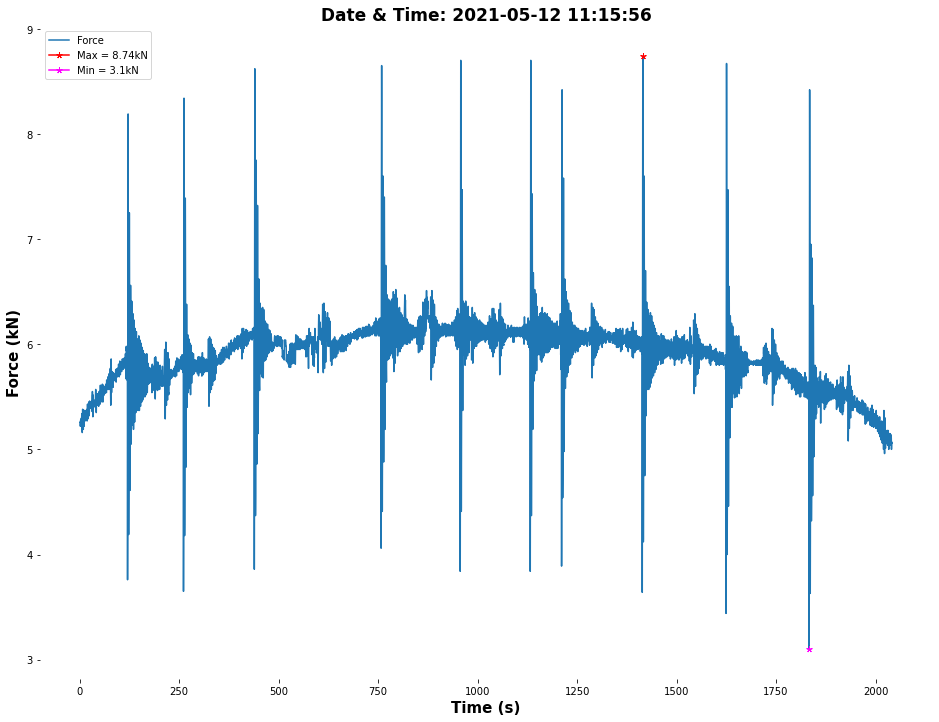

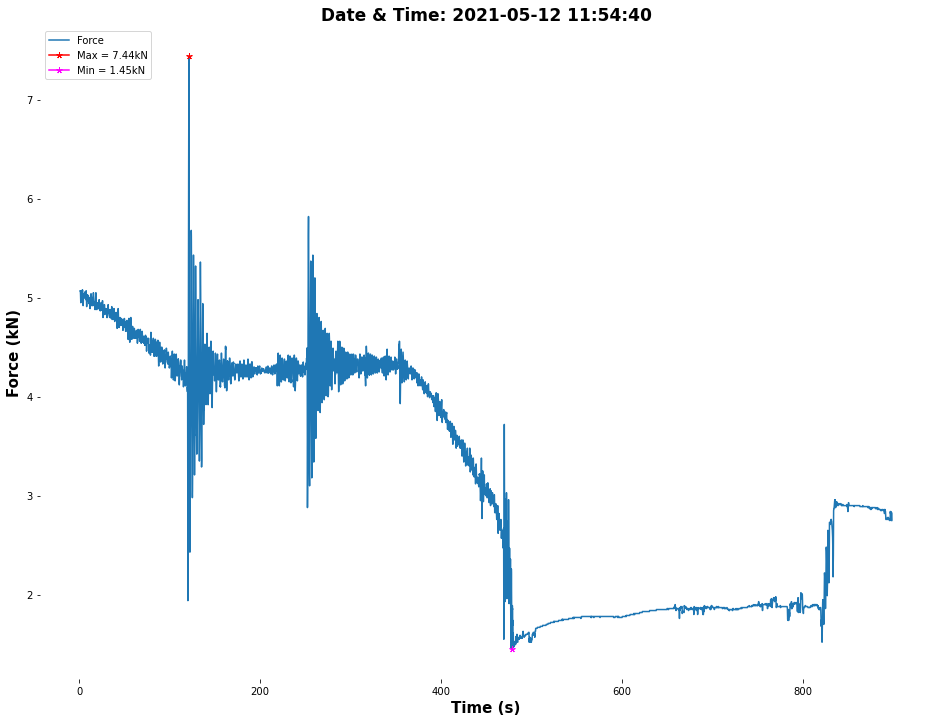

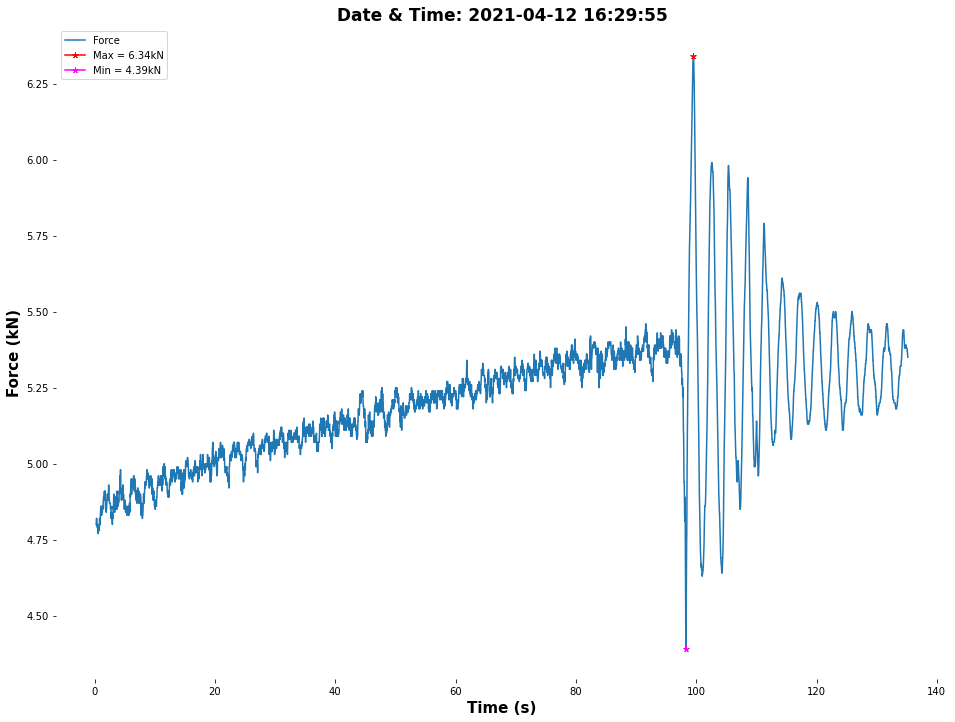

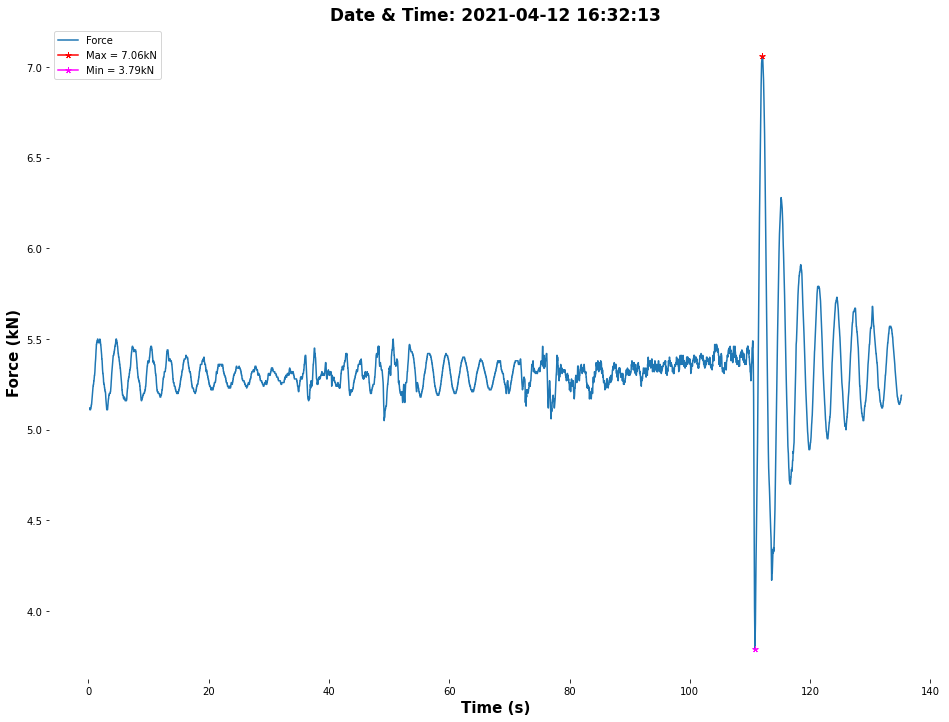

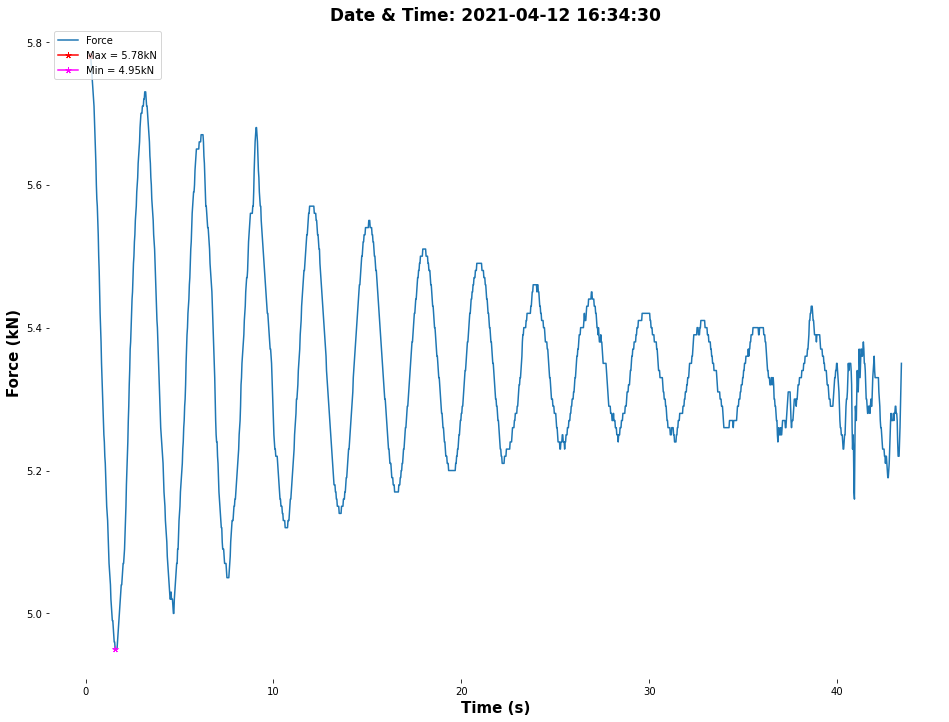

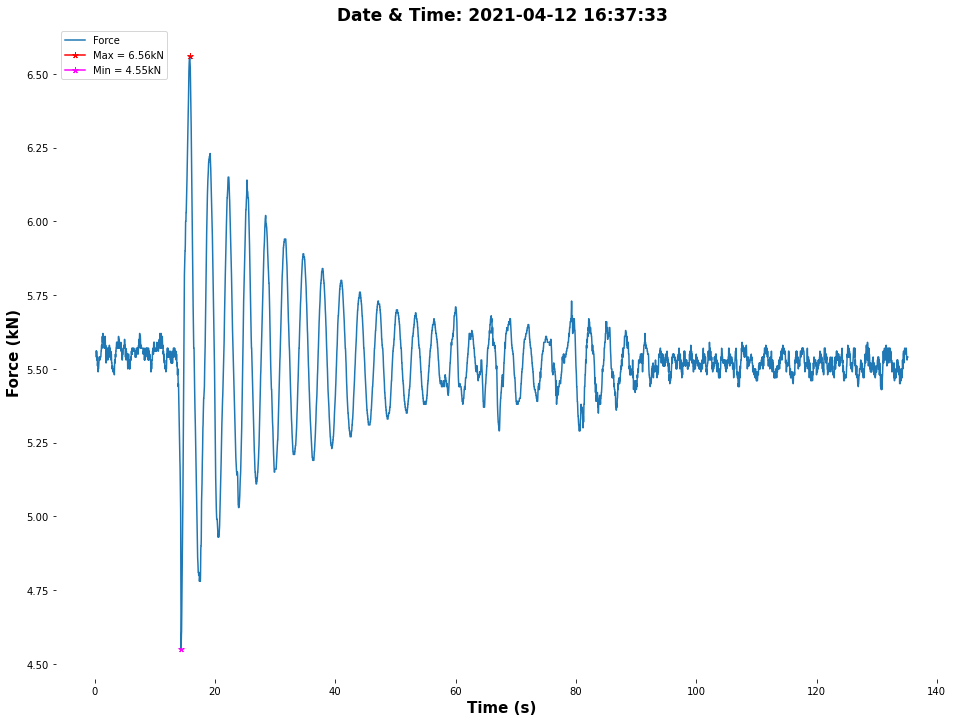

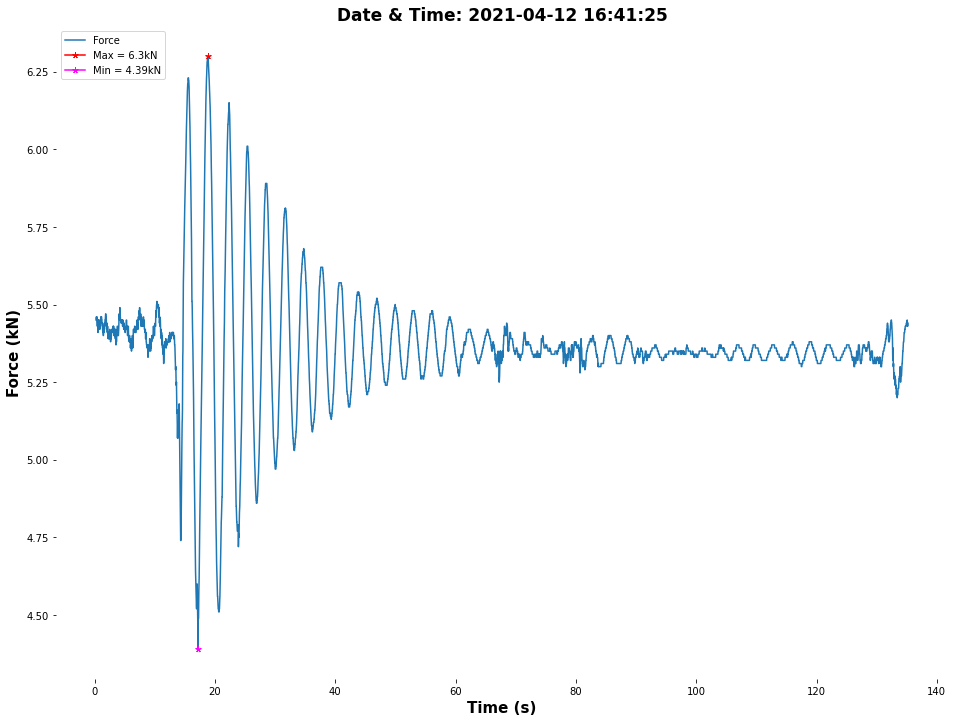

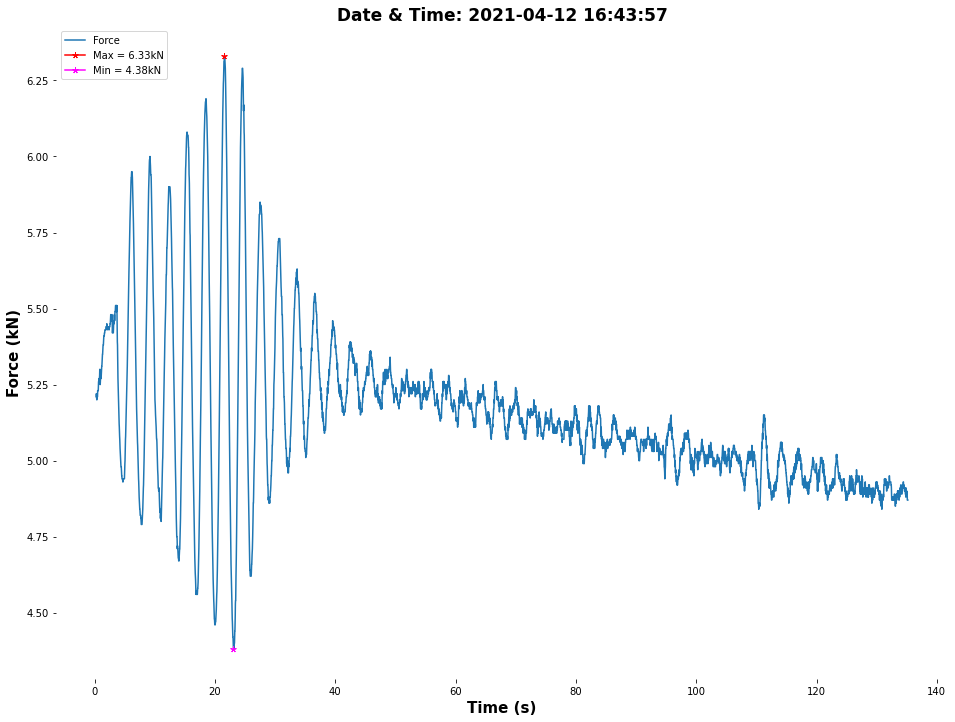

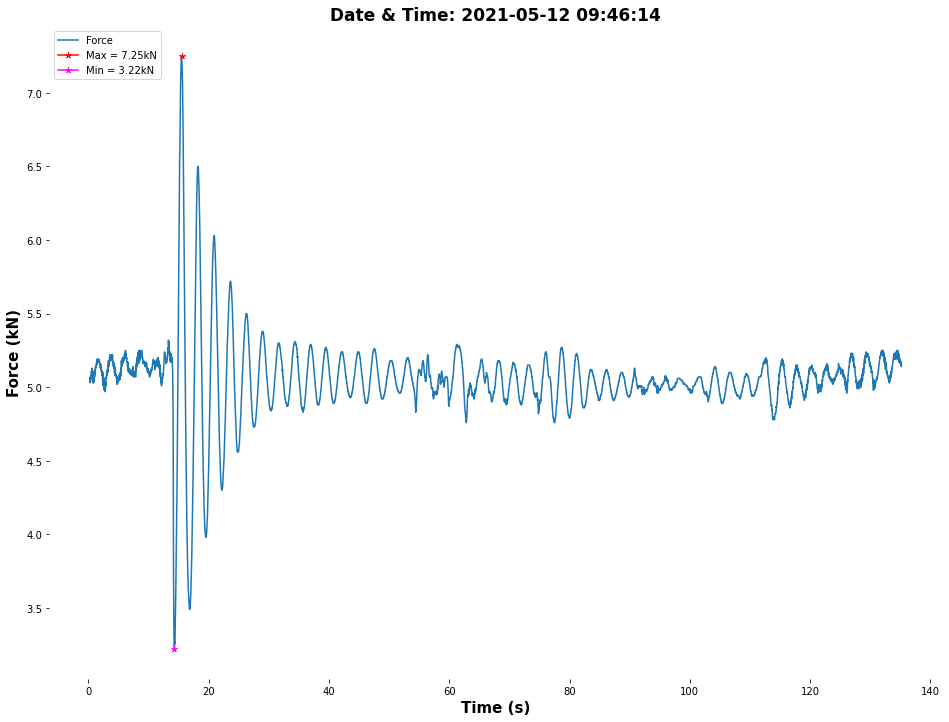

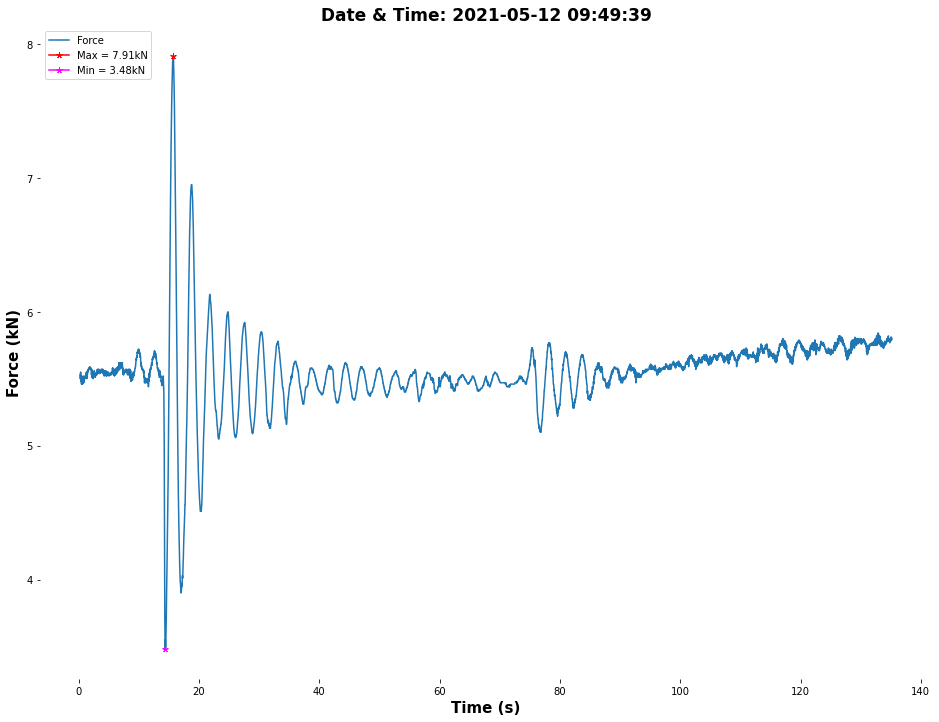

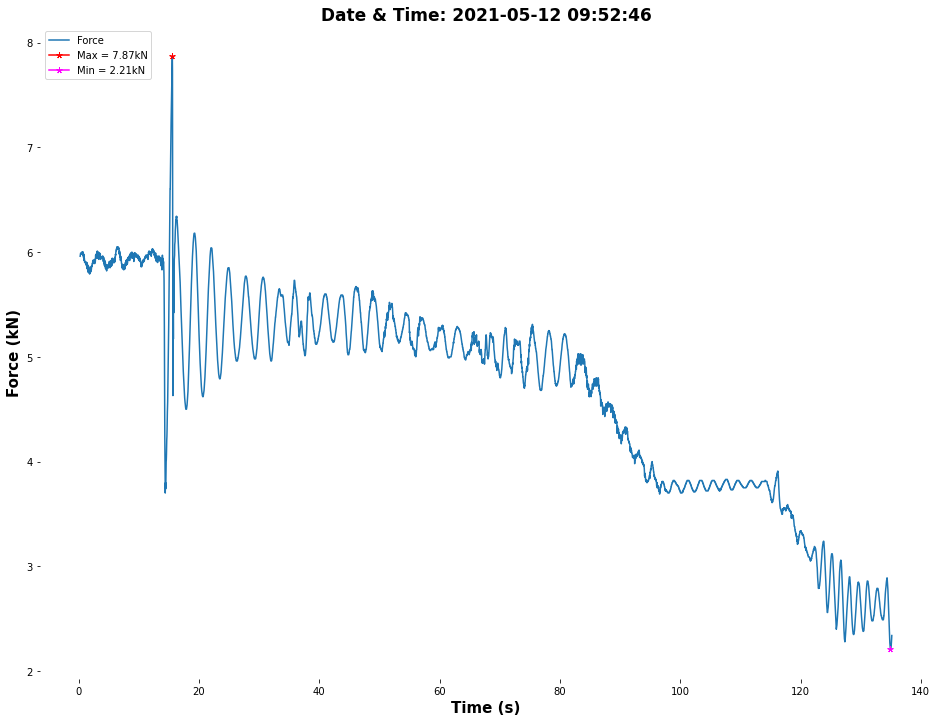

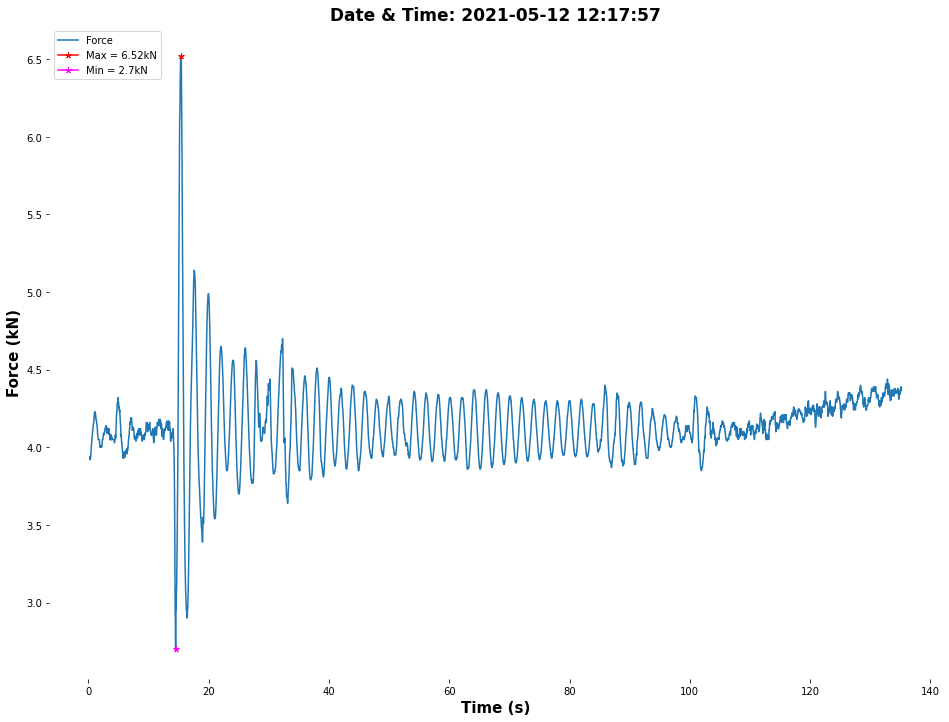

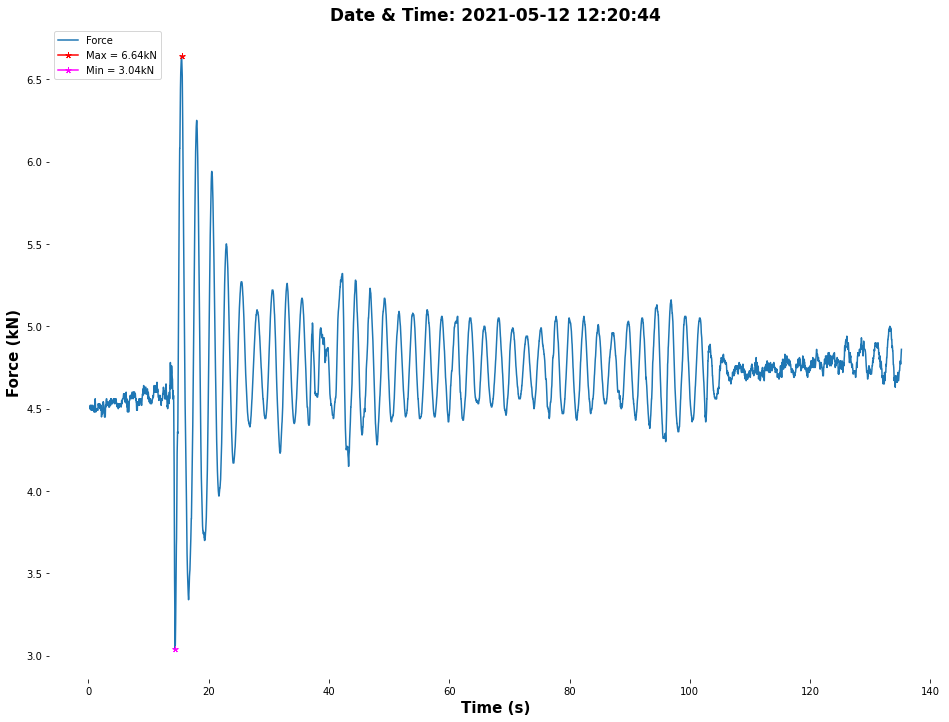

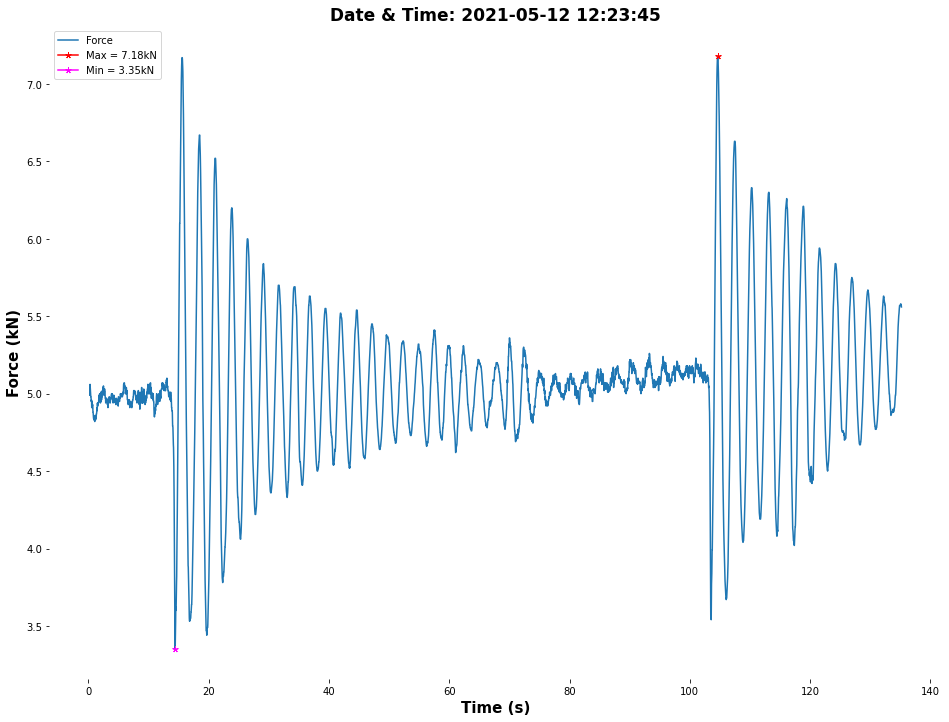

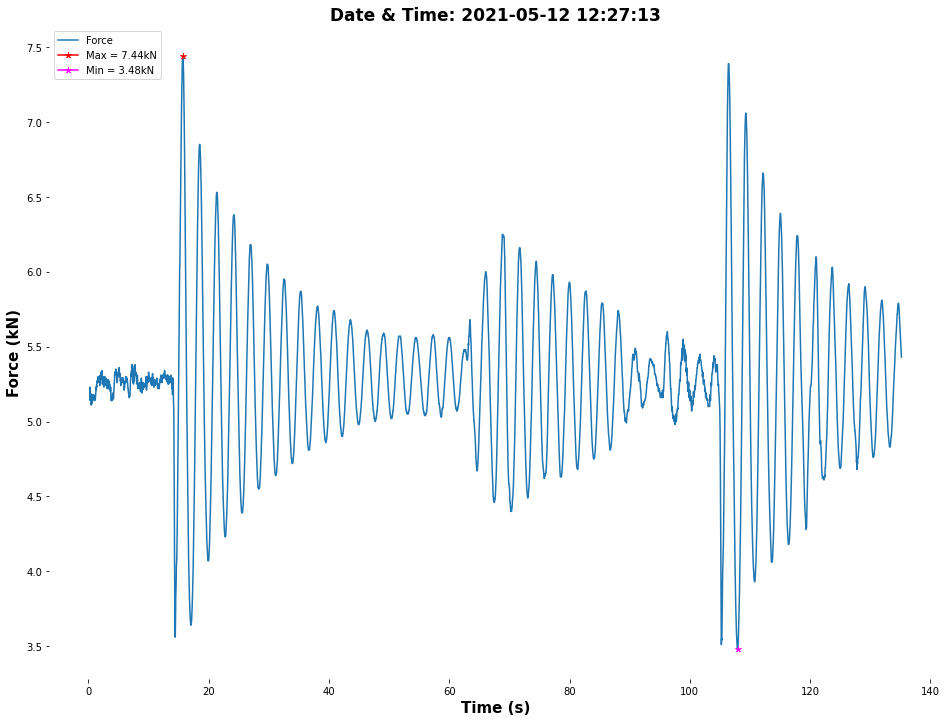

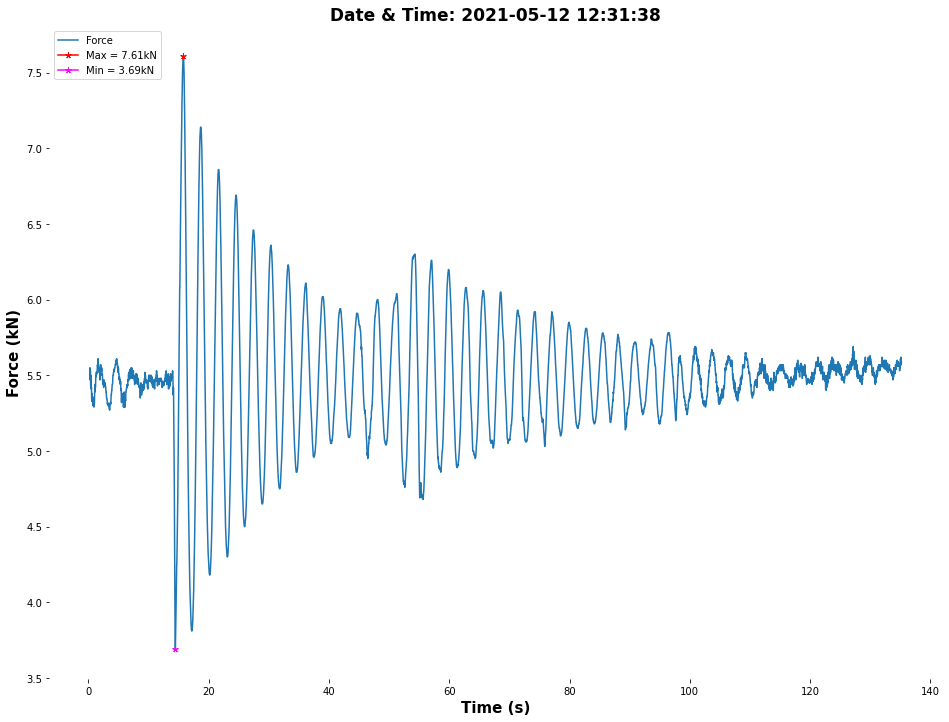

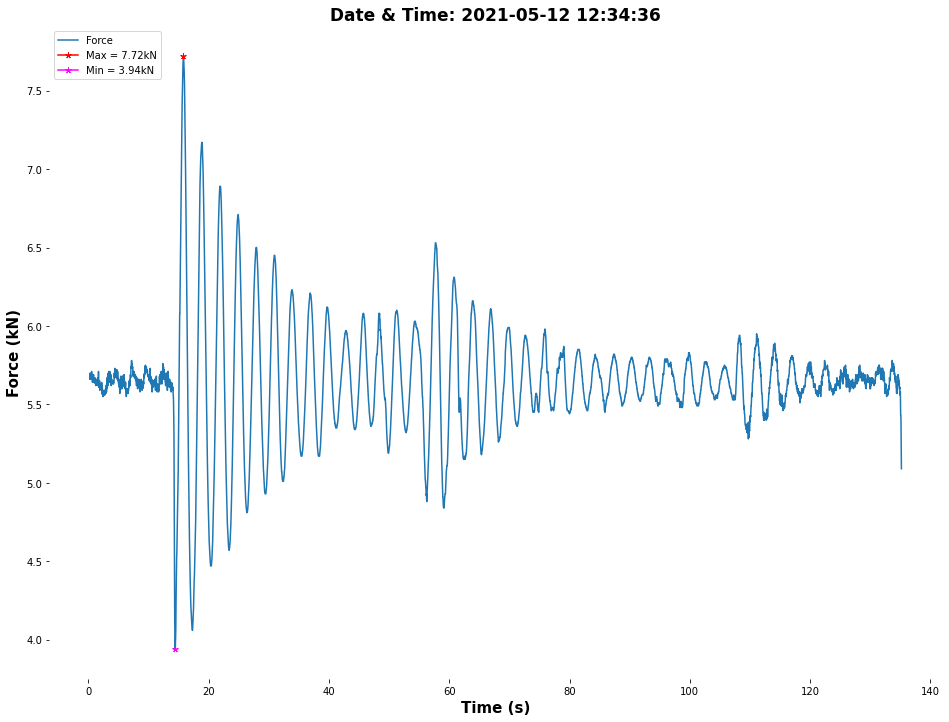

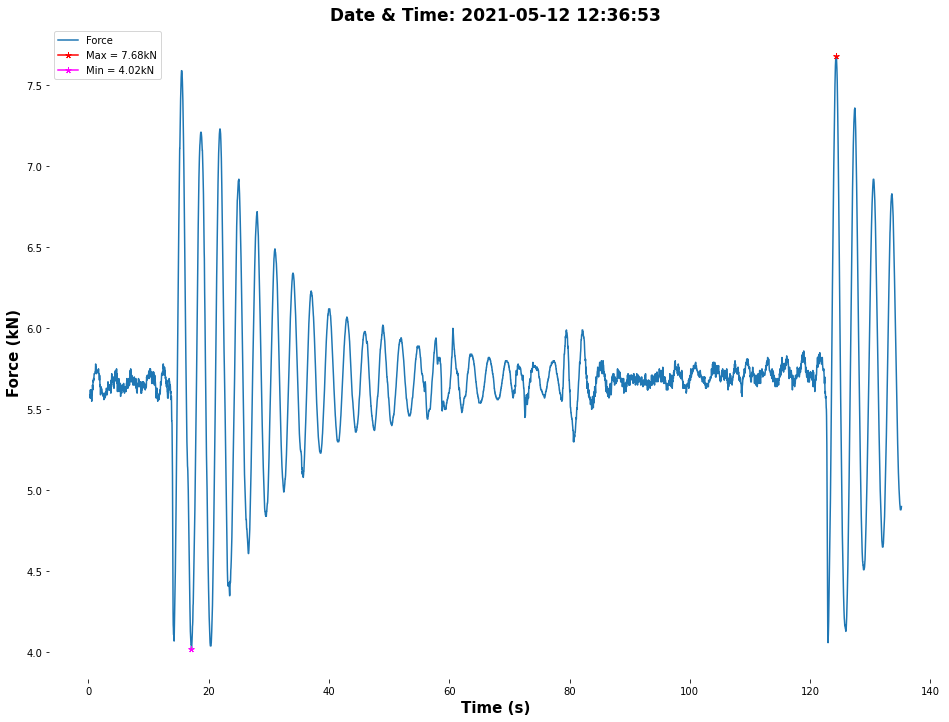

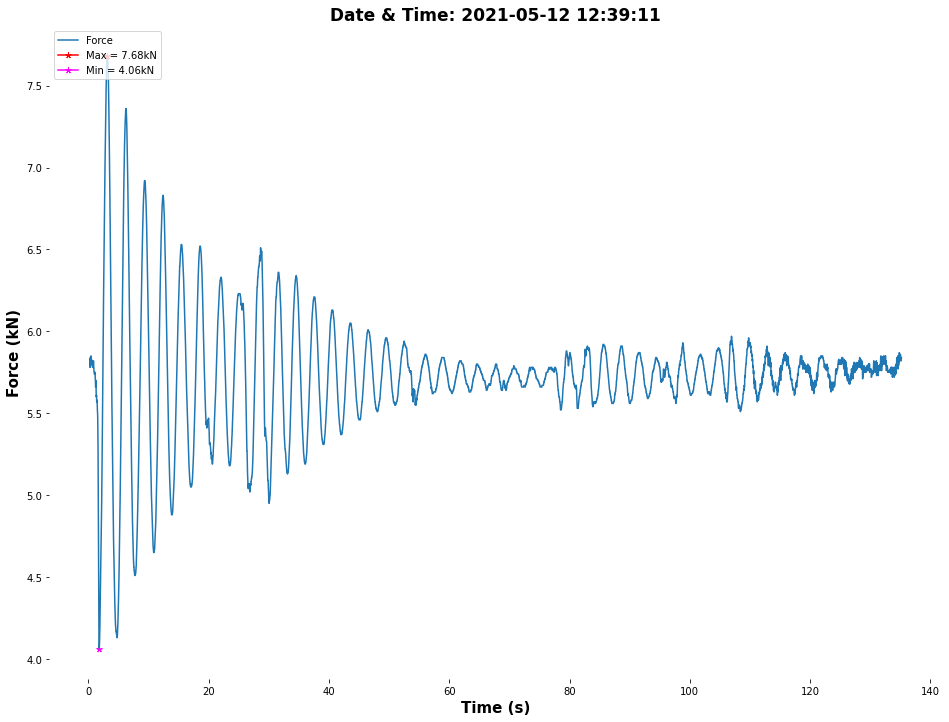

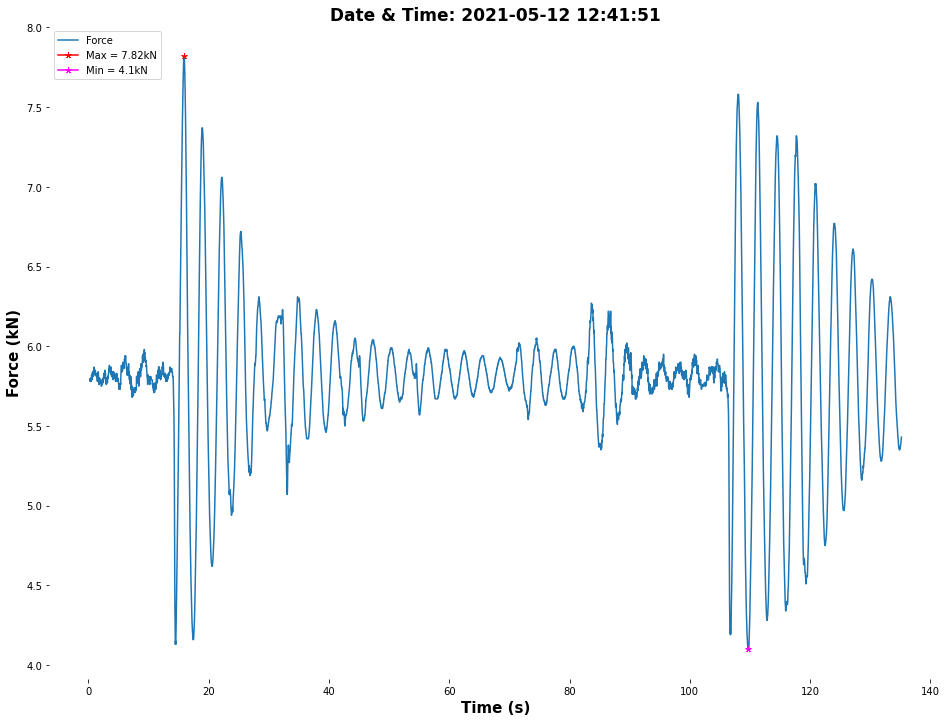

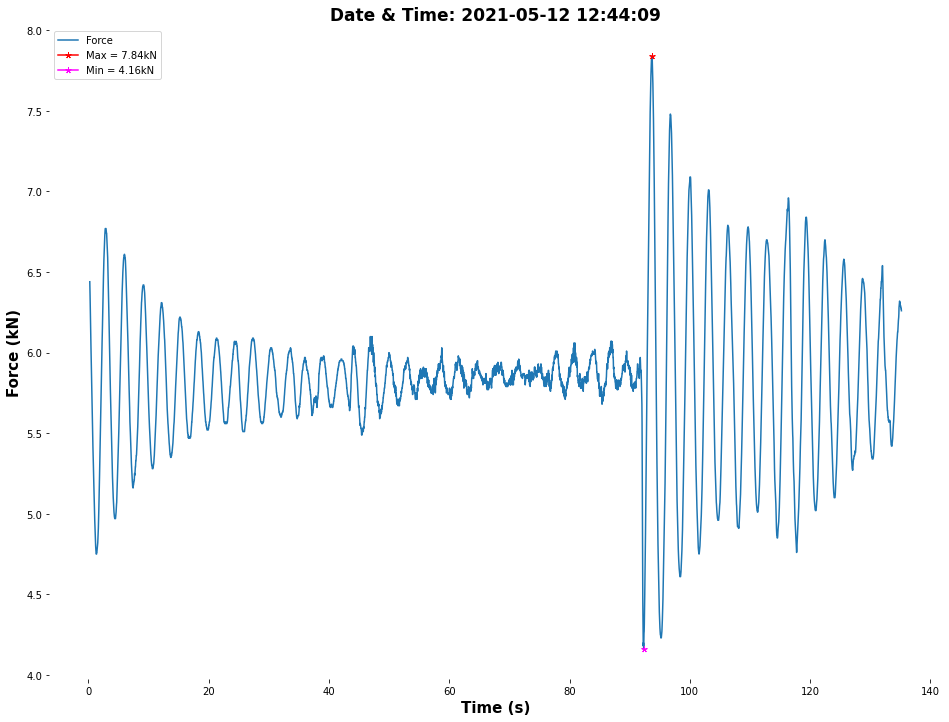

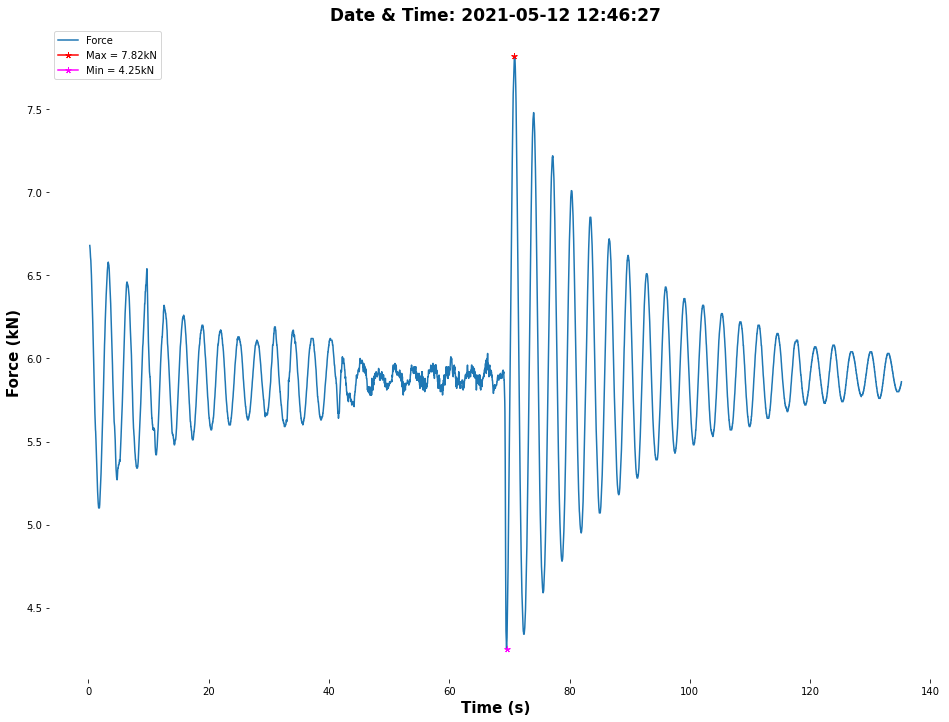

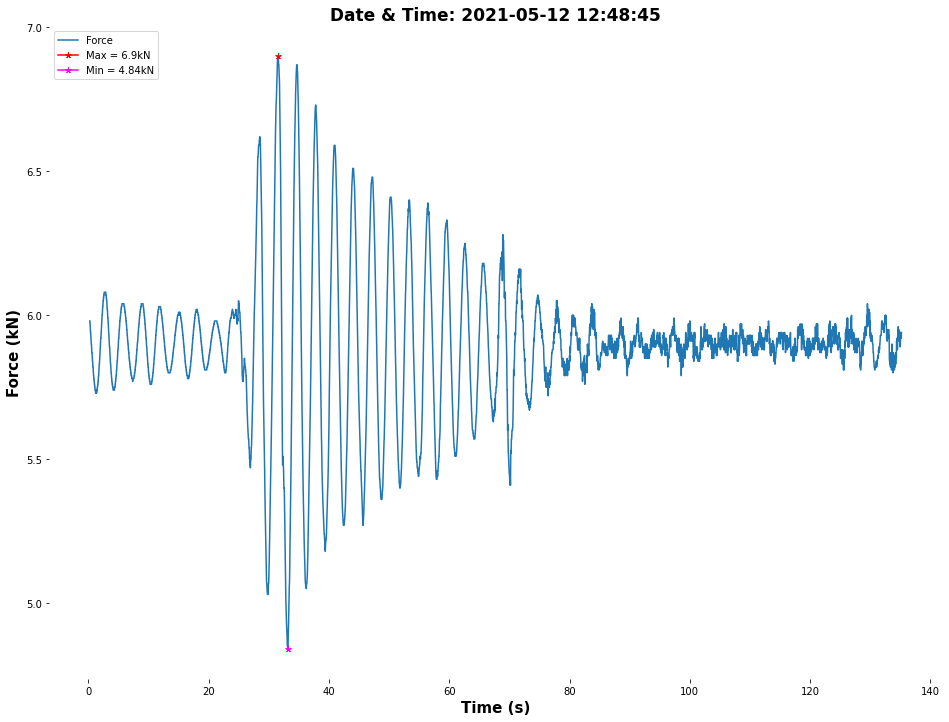

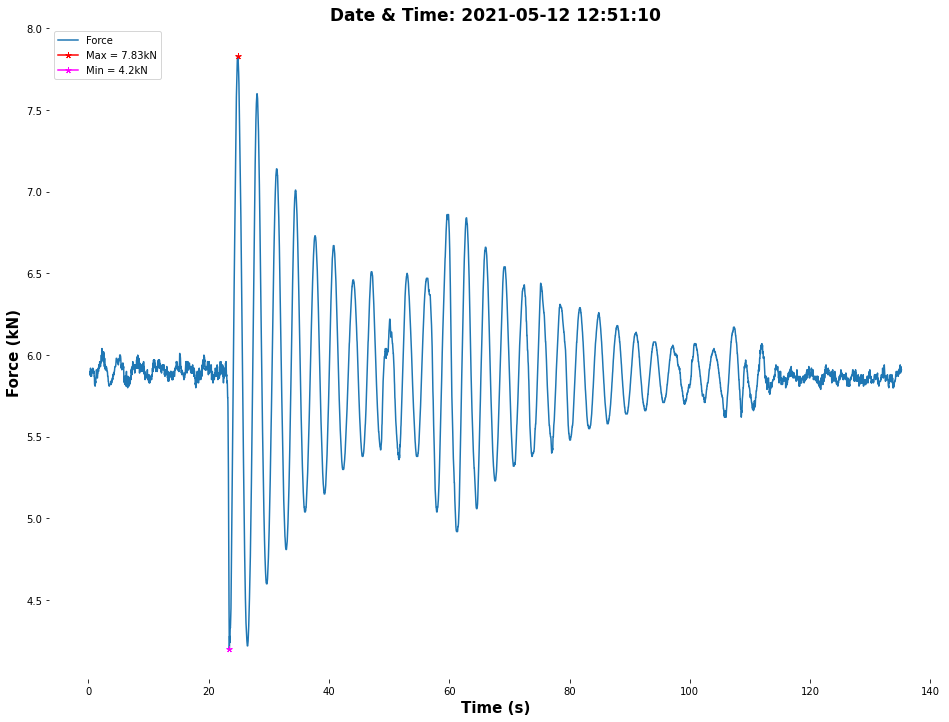

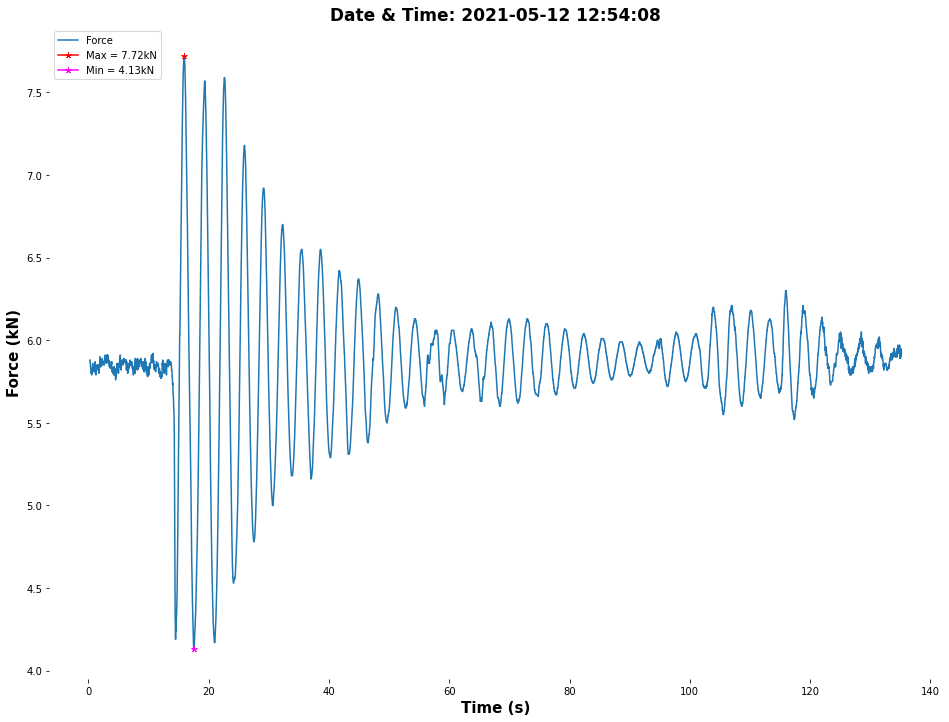

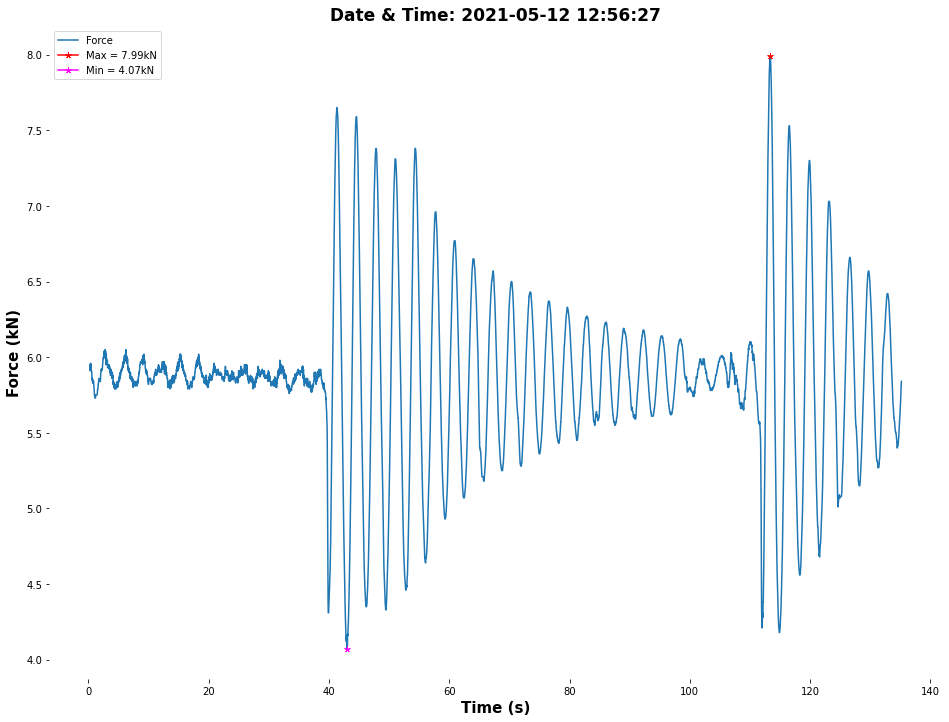

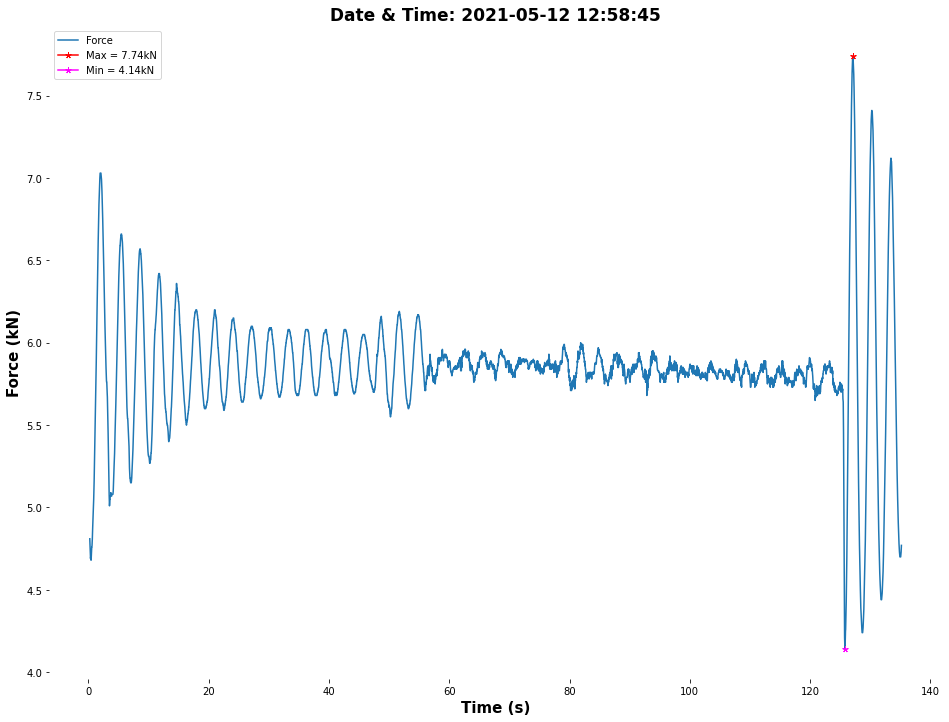

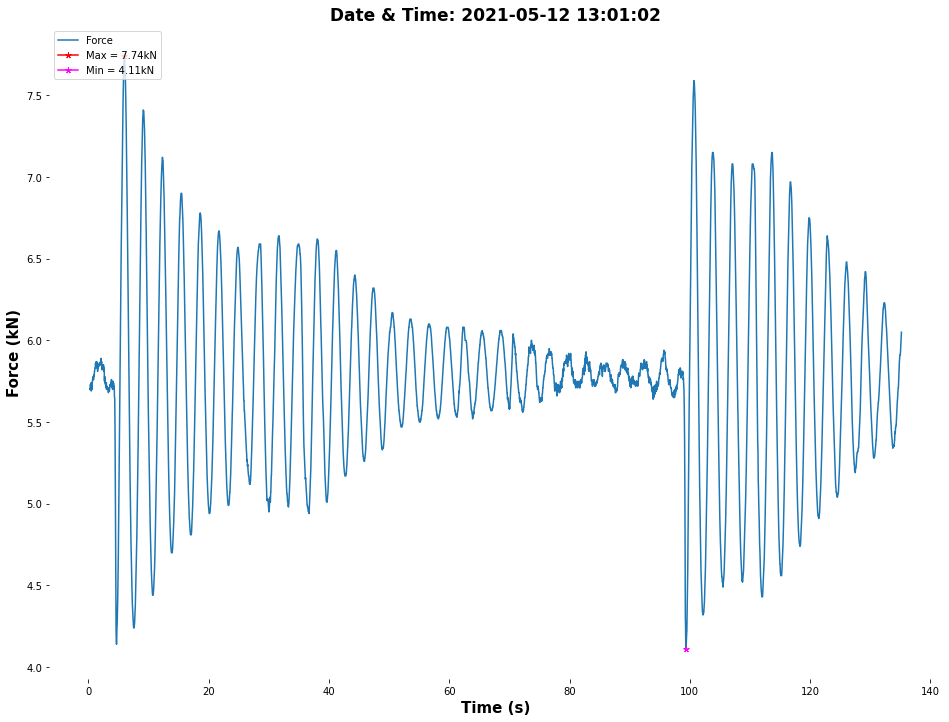

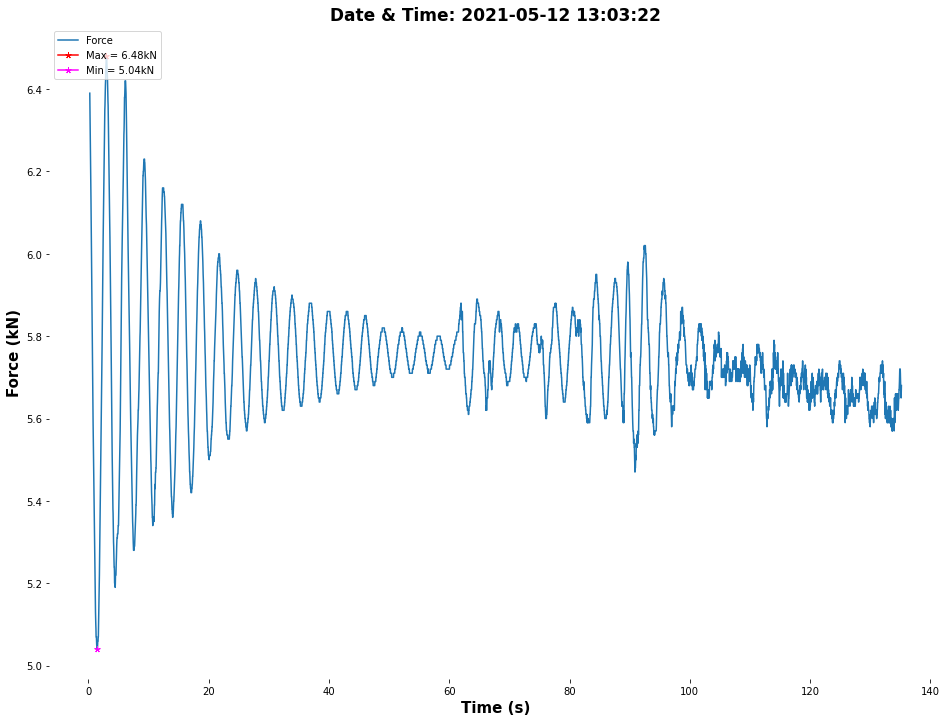

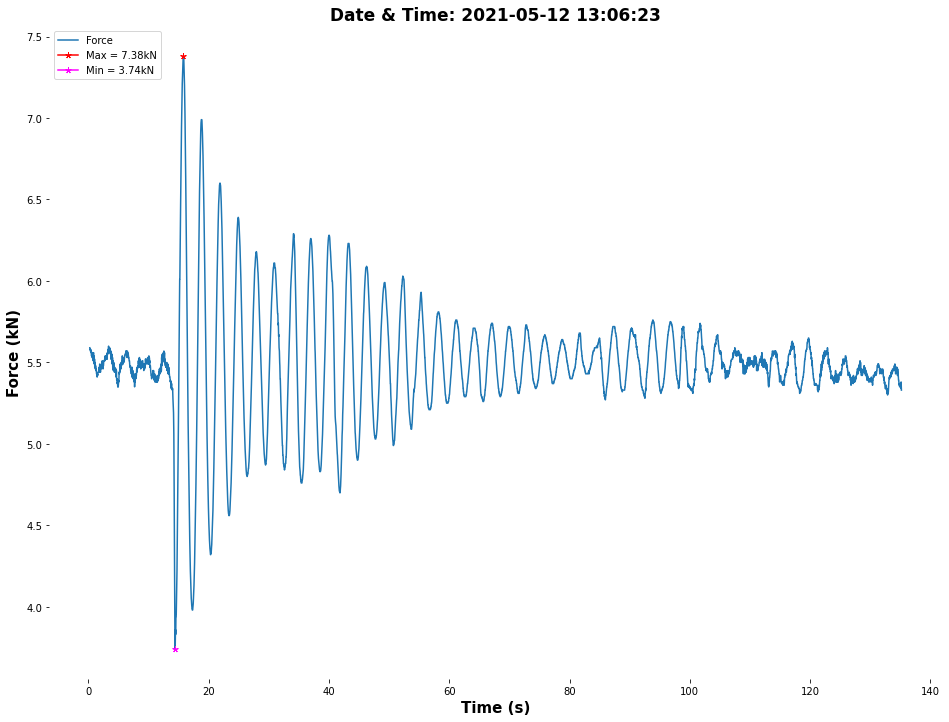

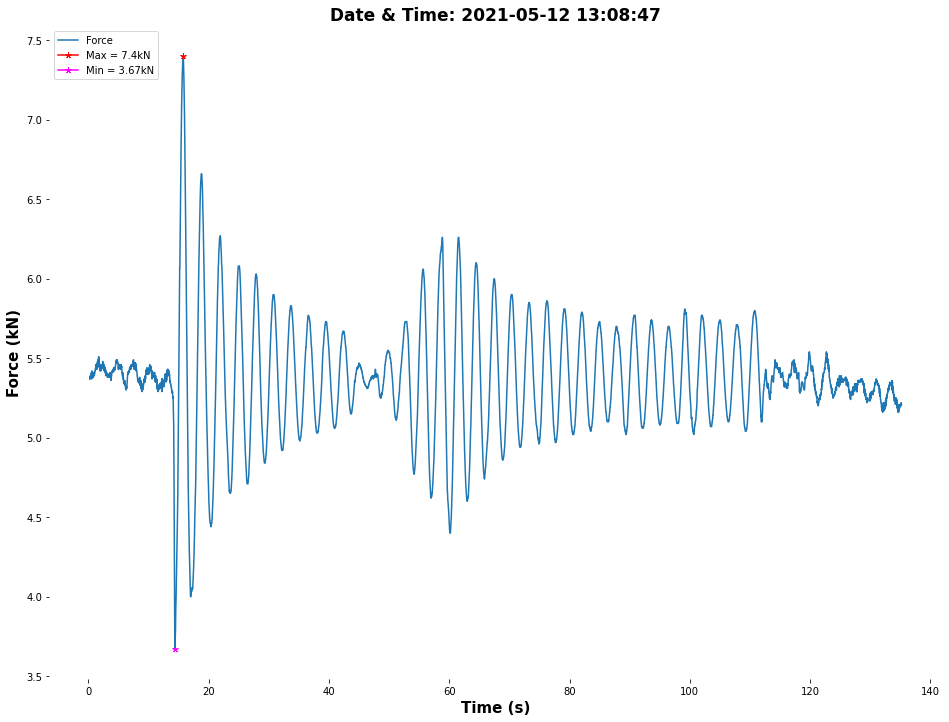

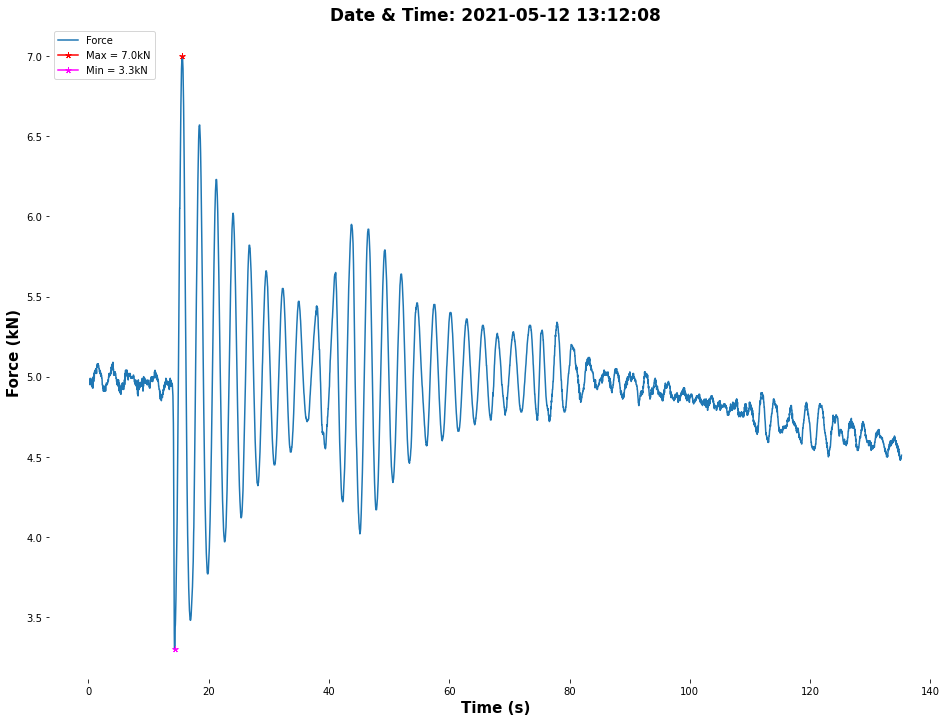

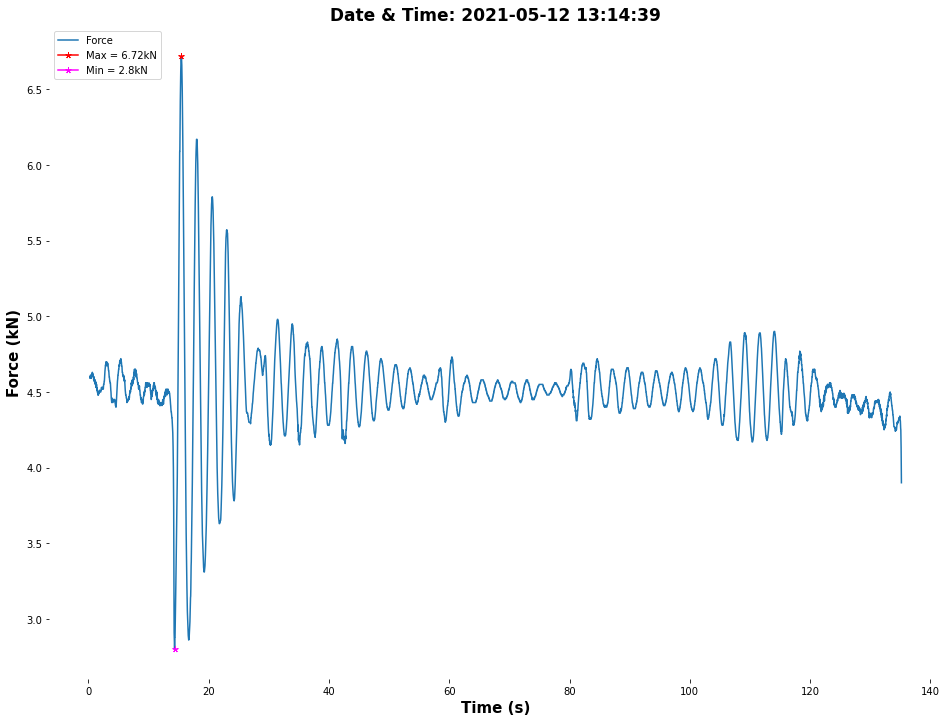

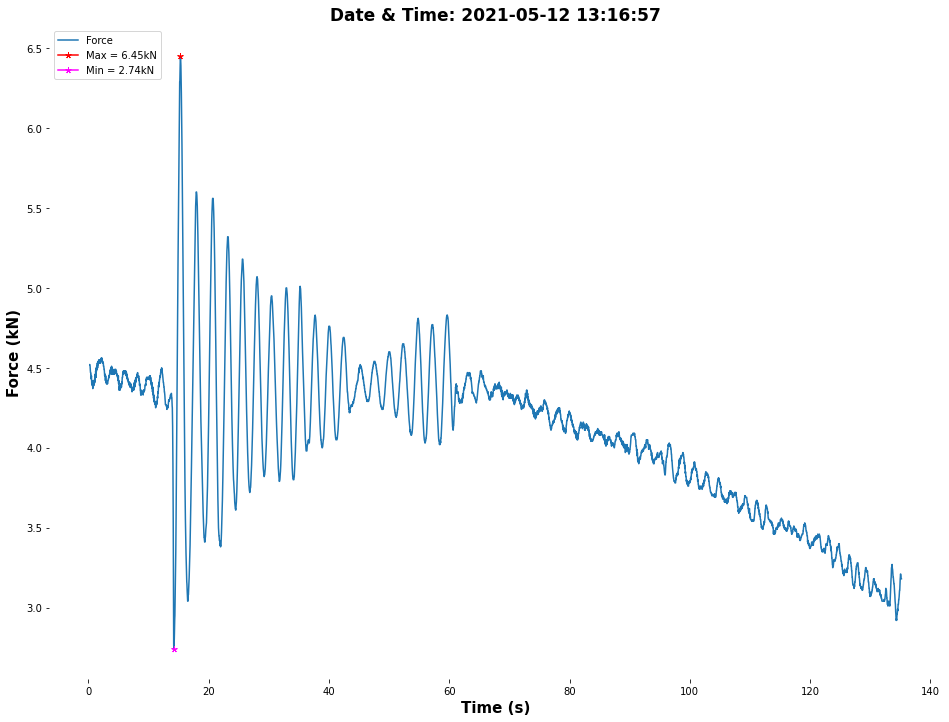

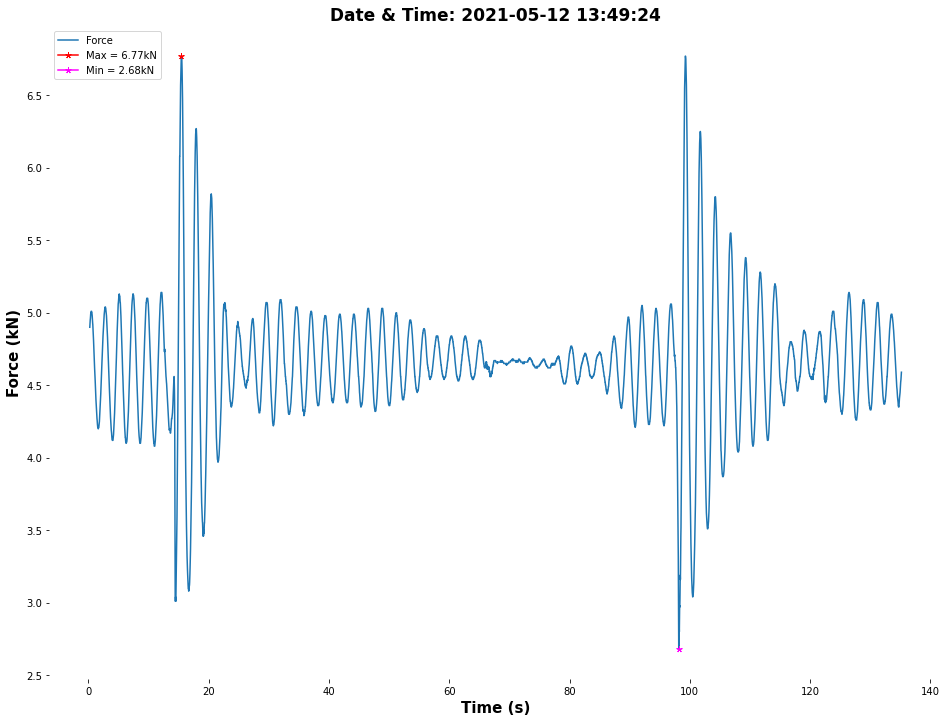

In [12]:
for i in df10.columns:
    plot_kN(df10, nums10, i)

for i in df40.columns:
    plot_kN(df40, nums40, i)
    
for i in df640.columns:
    plot_kN(df640, nums640, i)
    
for i in df1280.columns:
    plot_kN(df1280, nums1280, i)

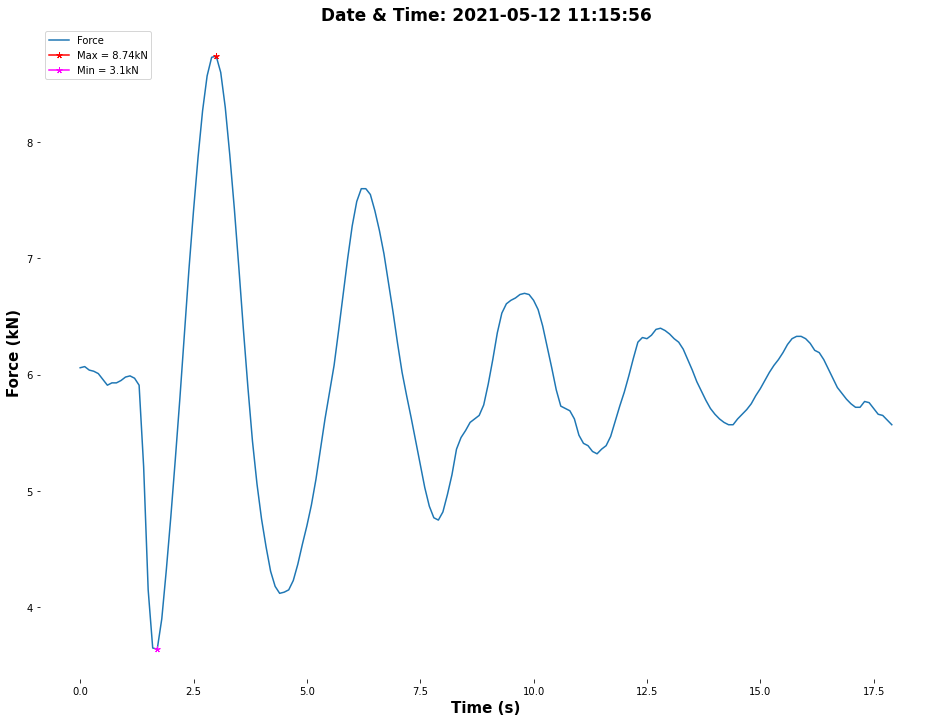

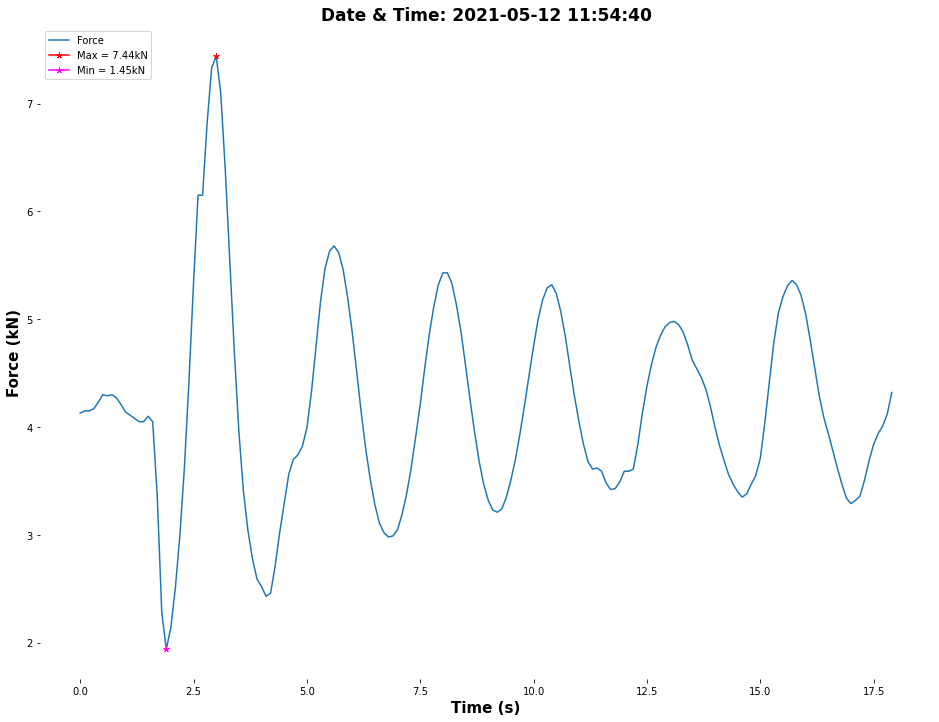

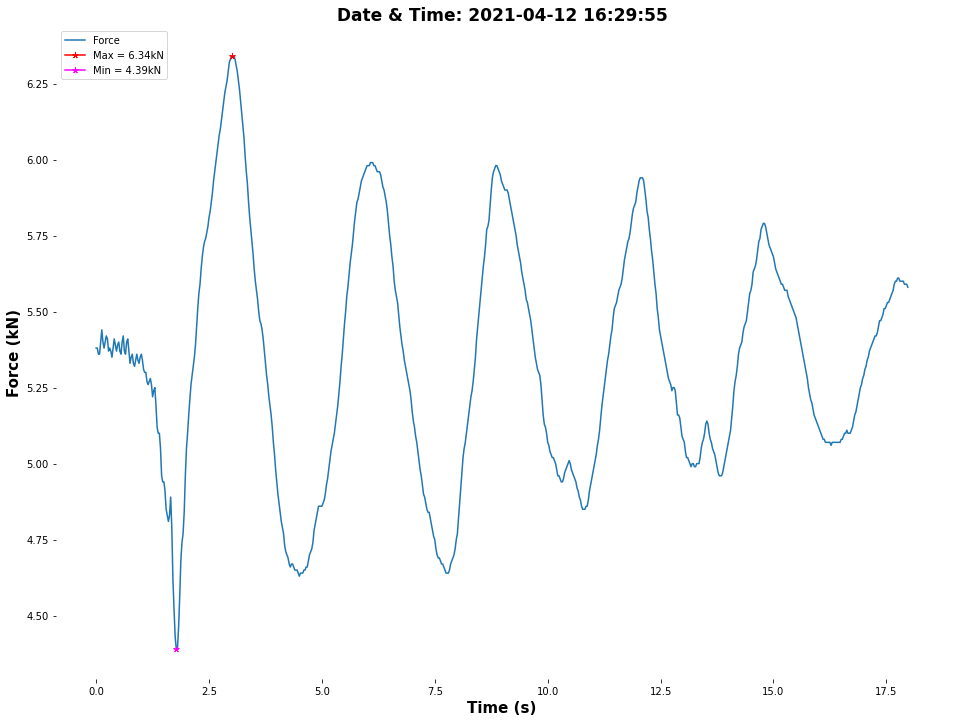

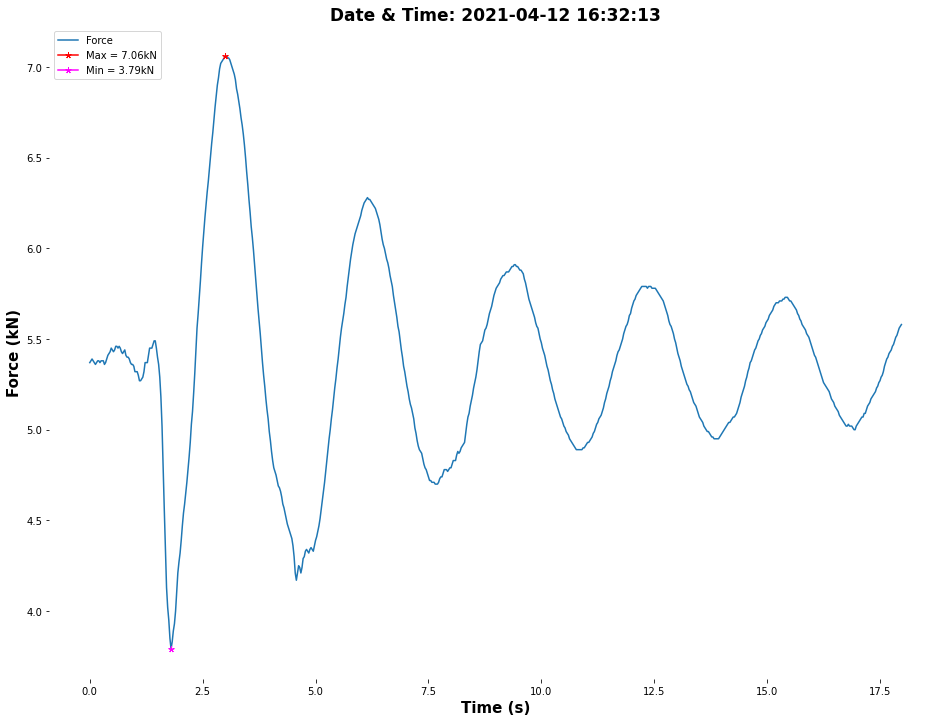

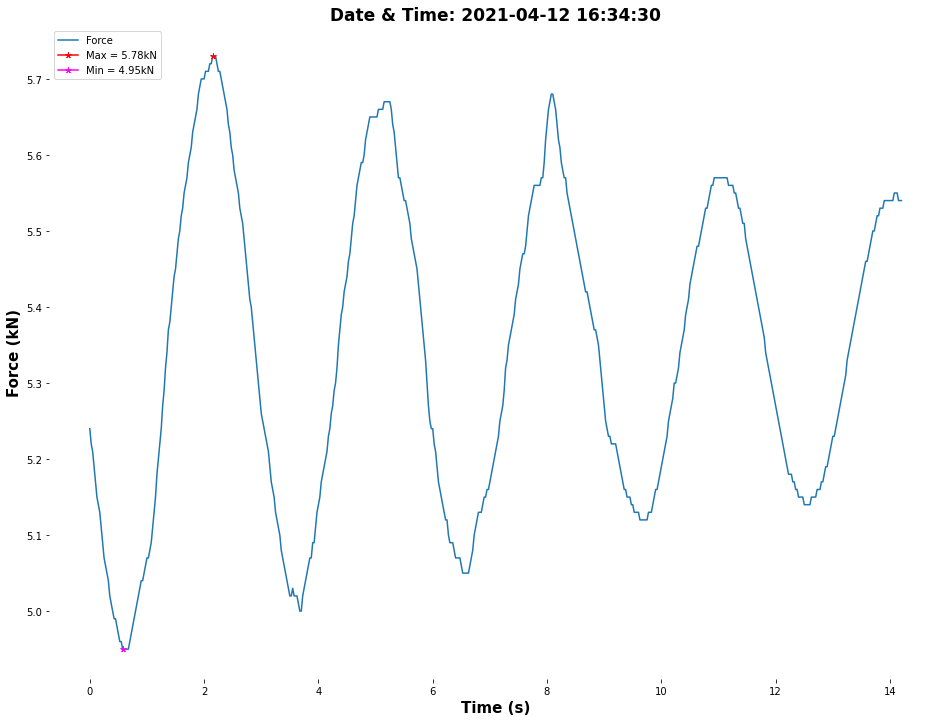

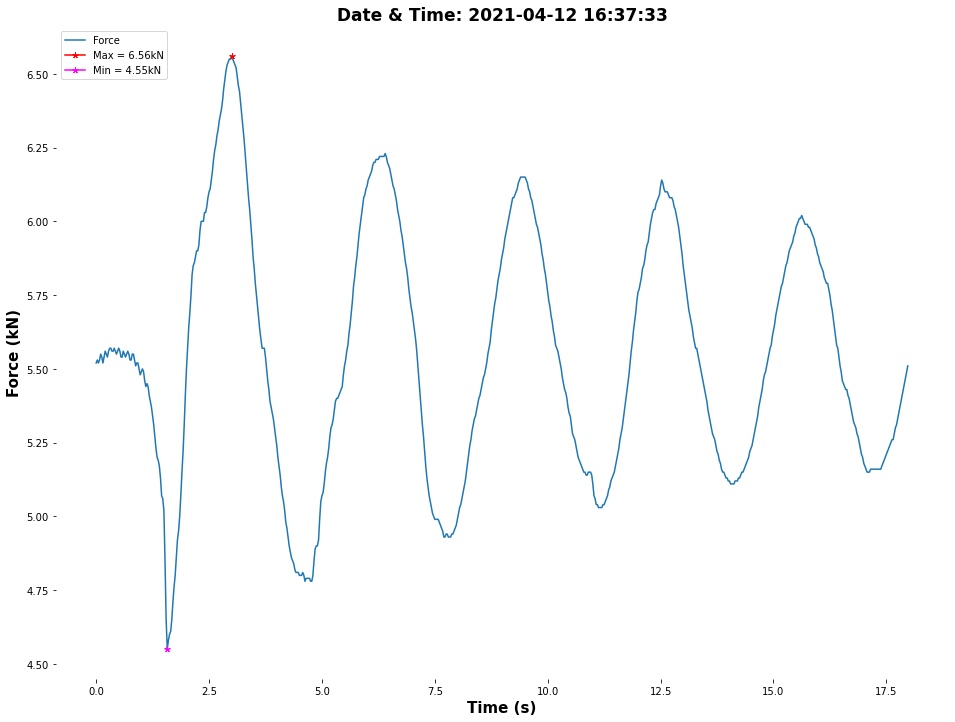

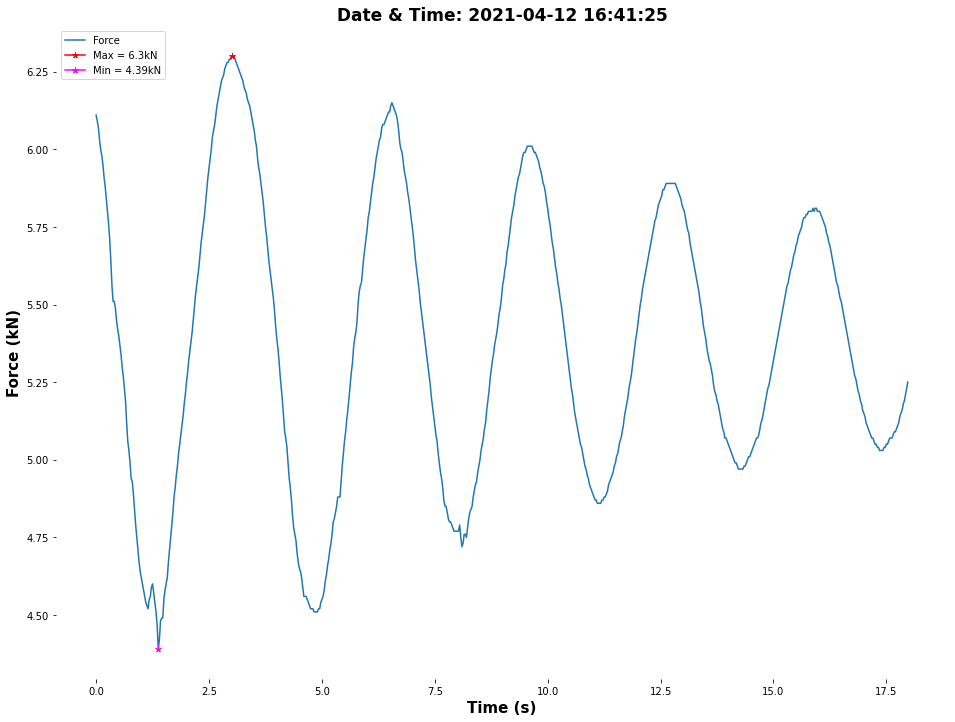

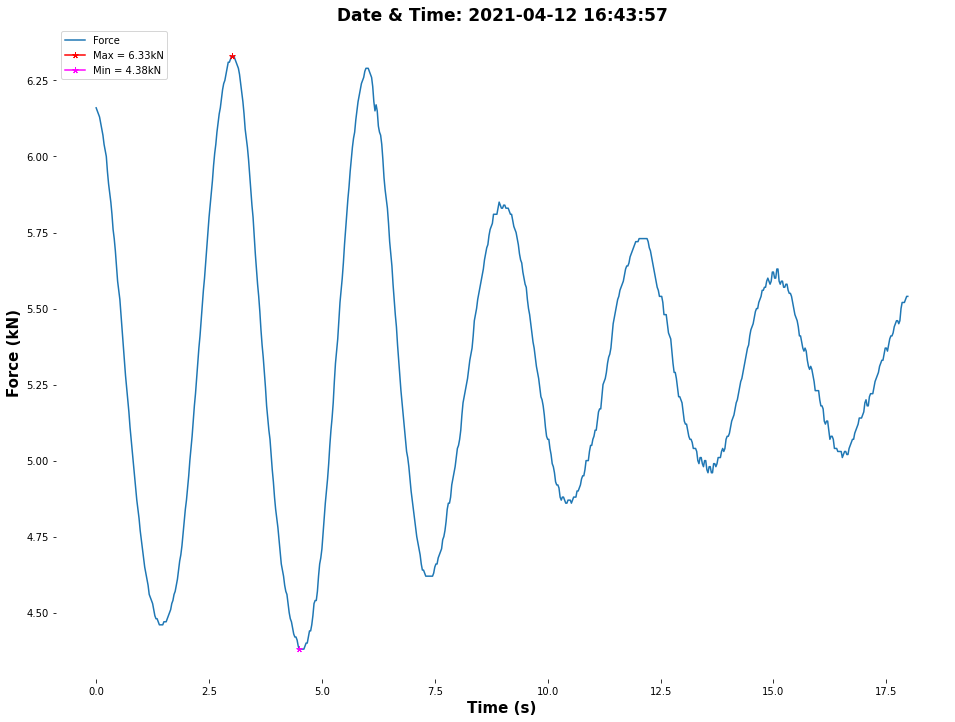

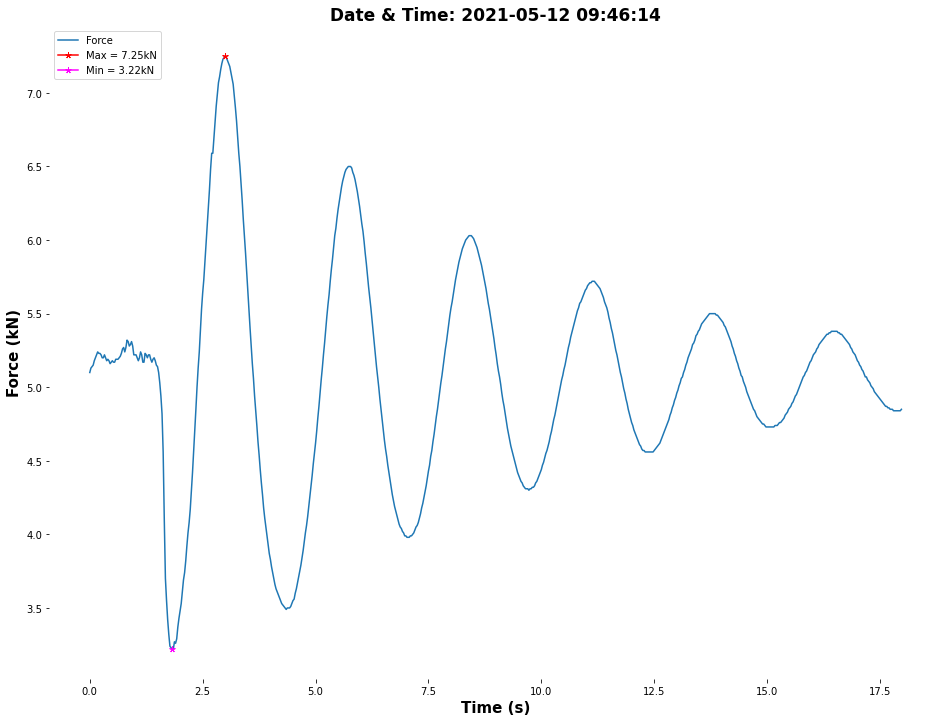

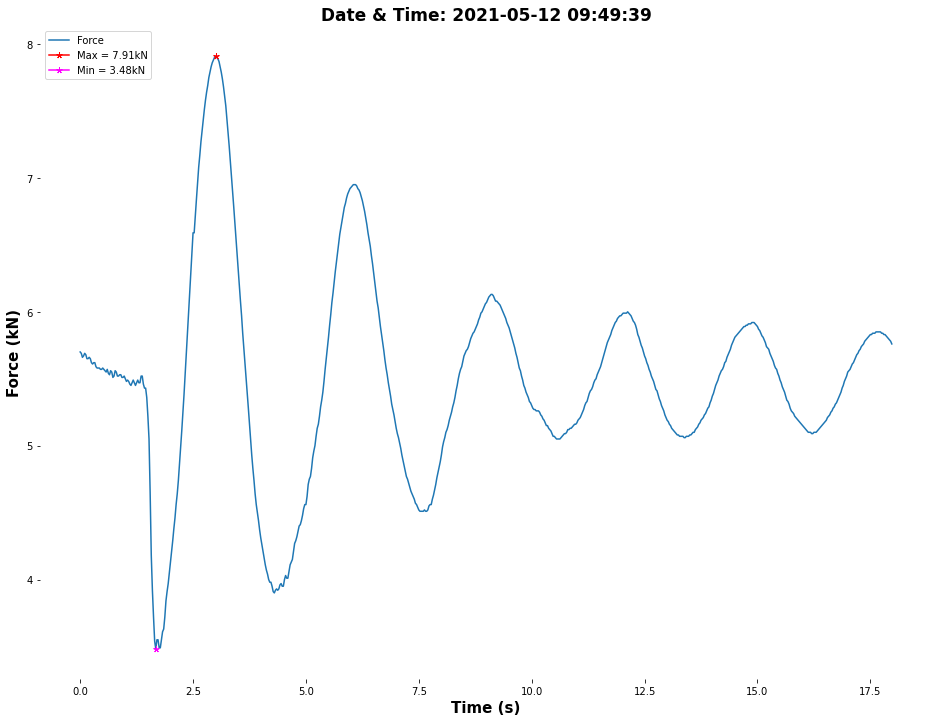

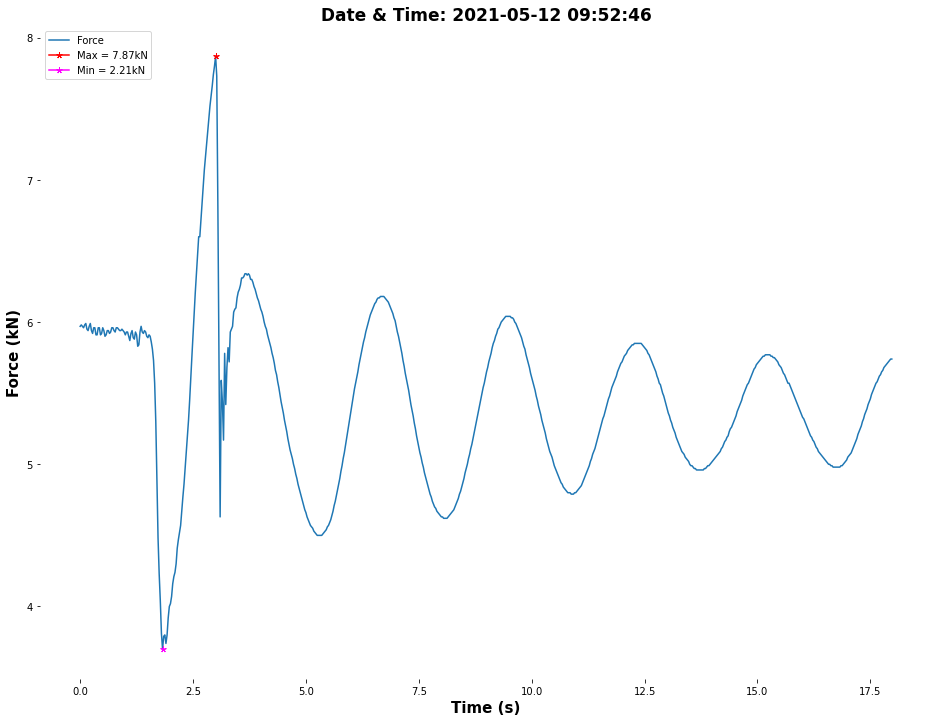

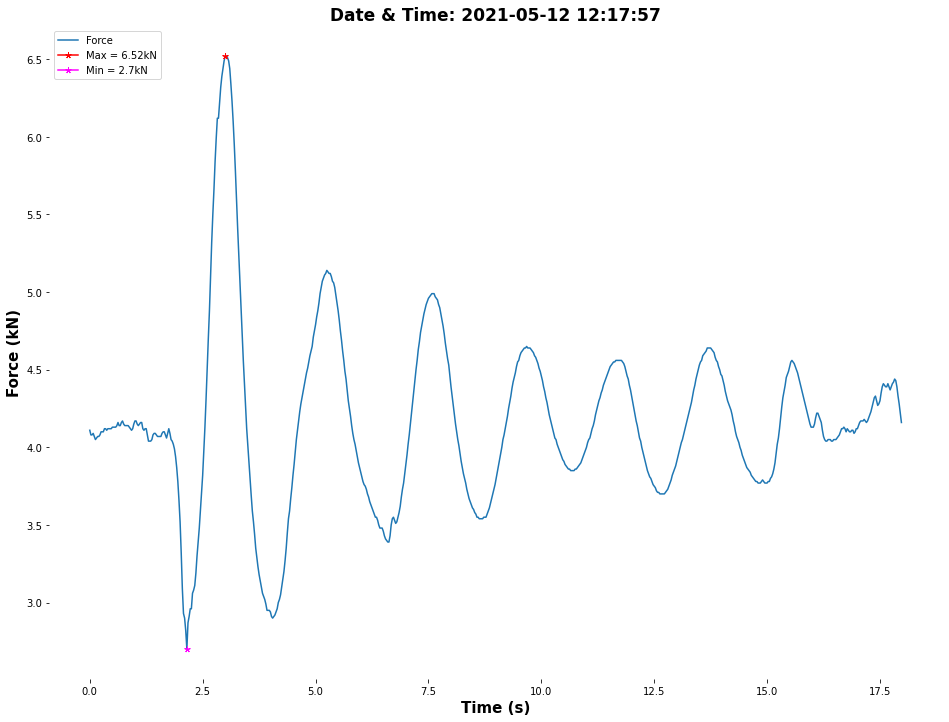

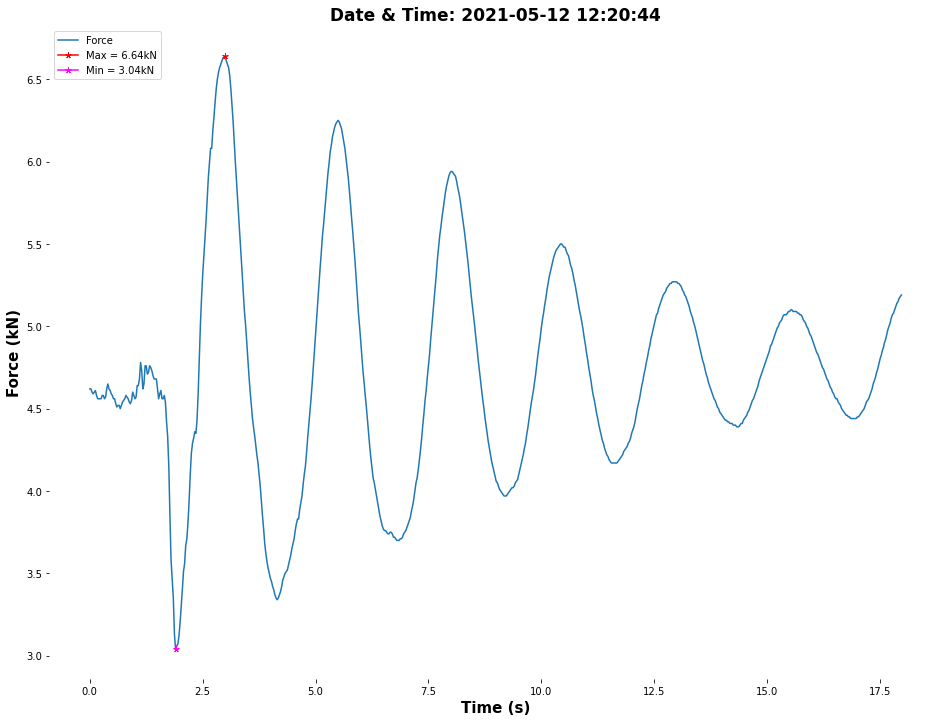

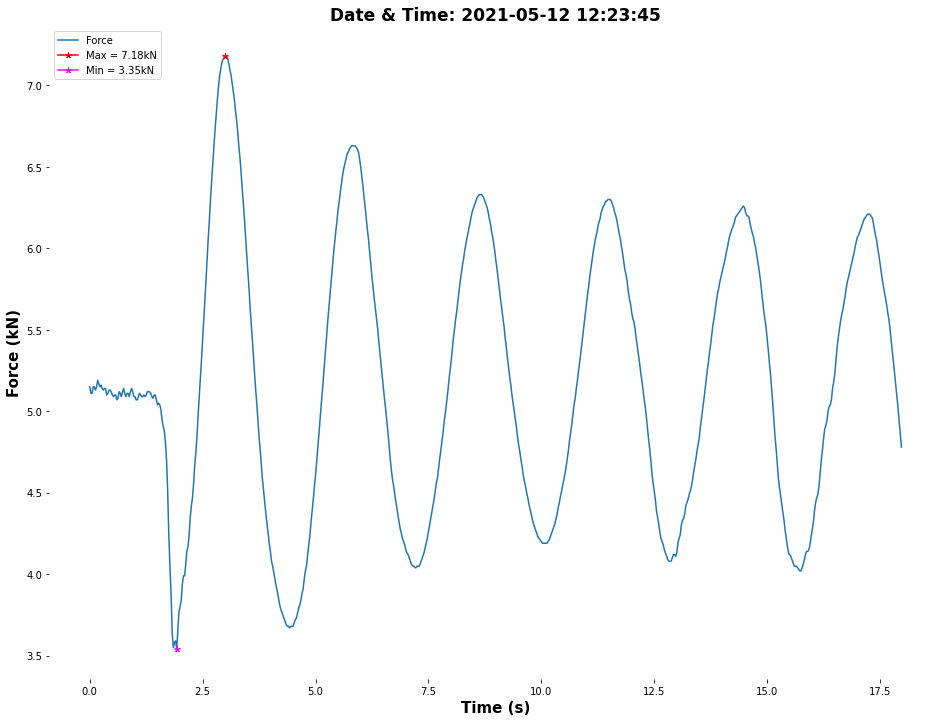

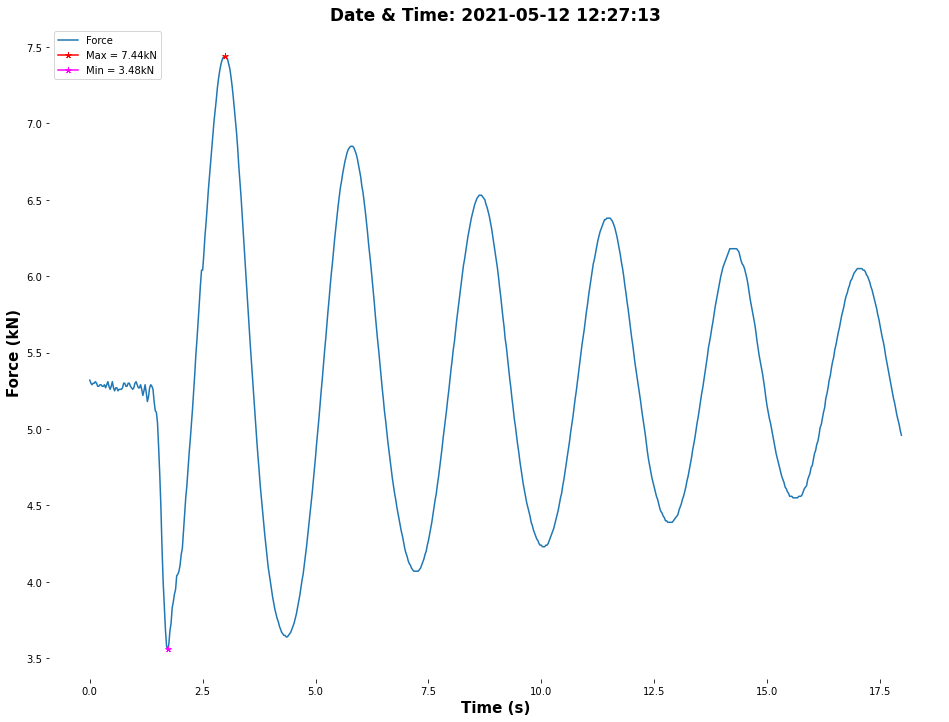

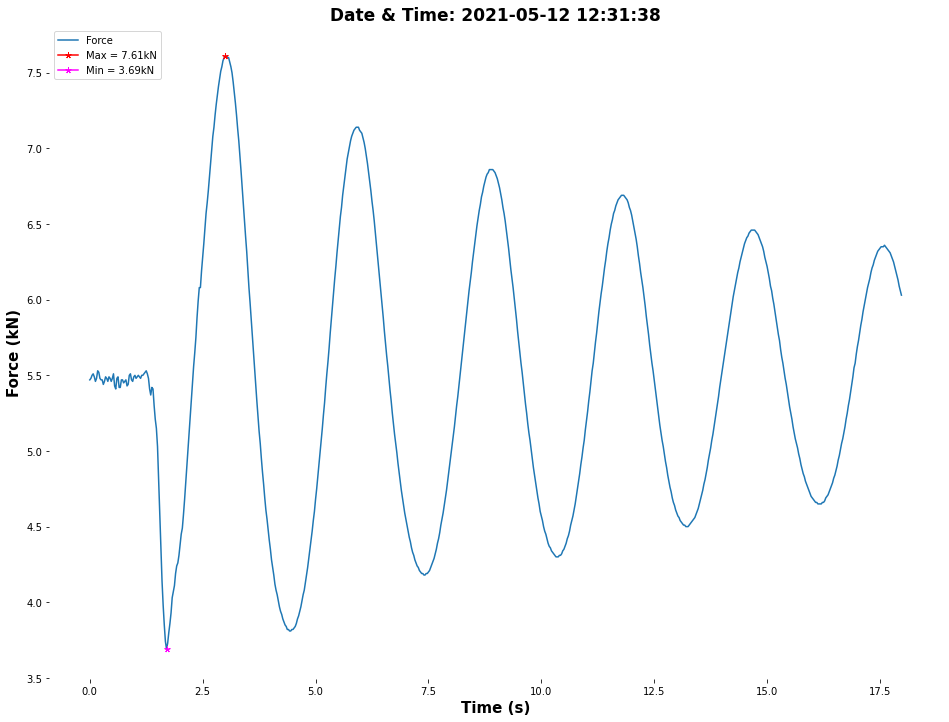

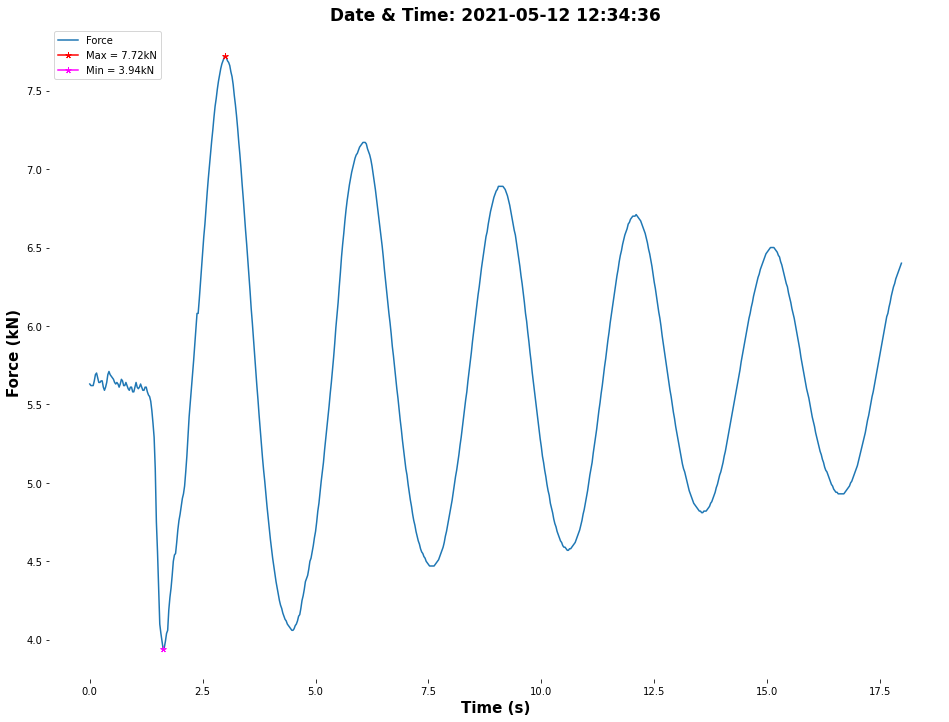

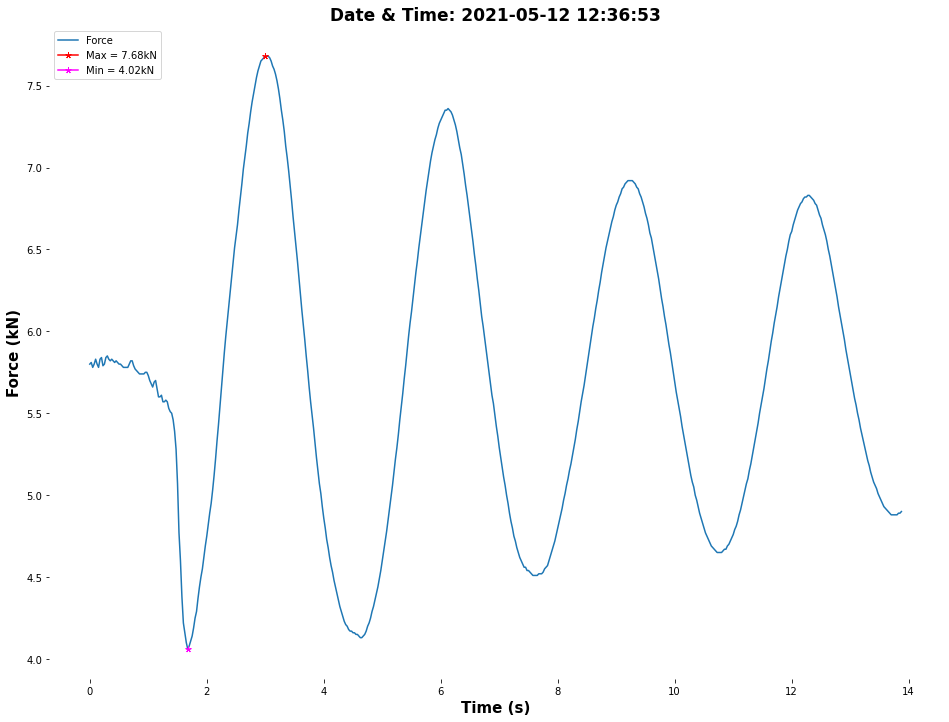

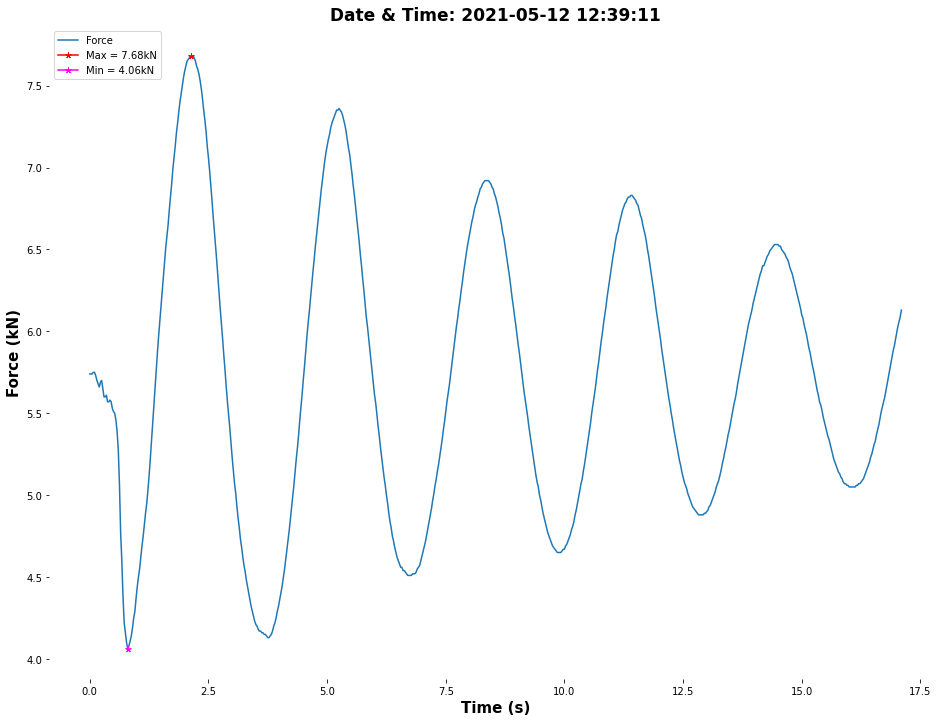

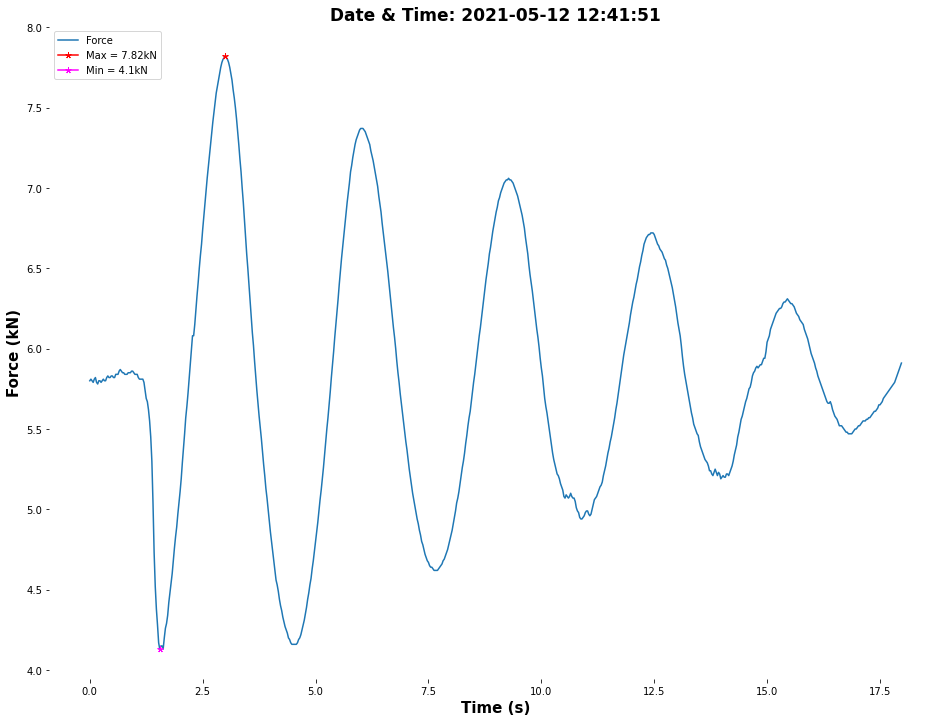

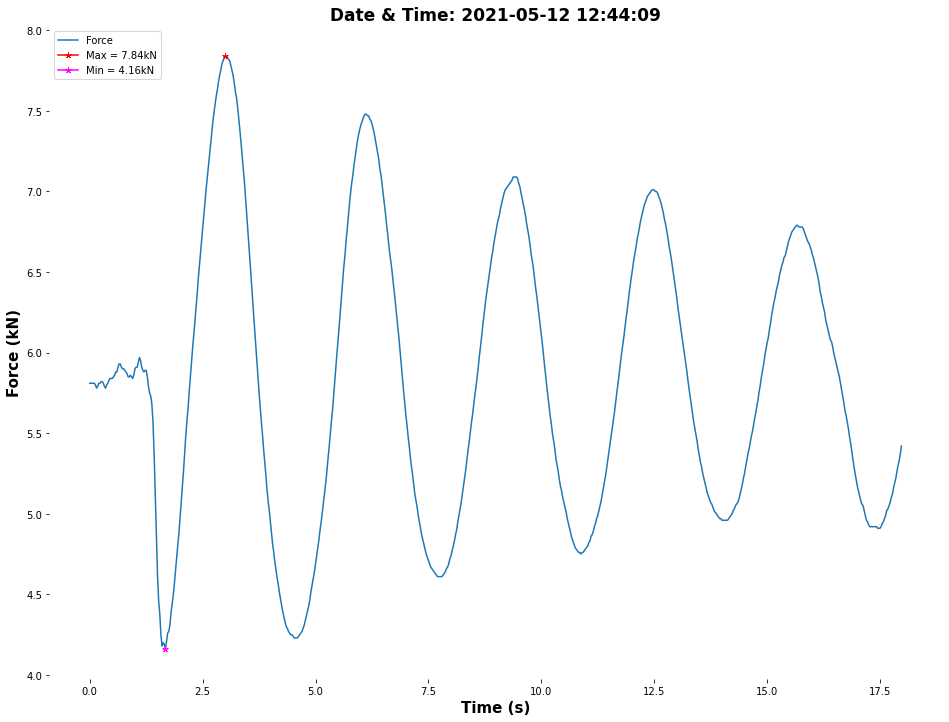

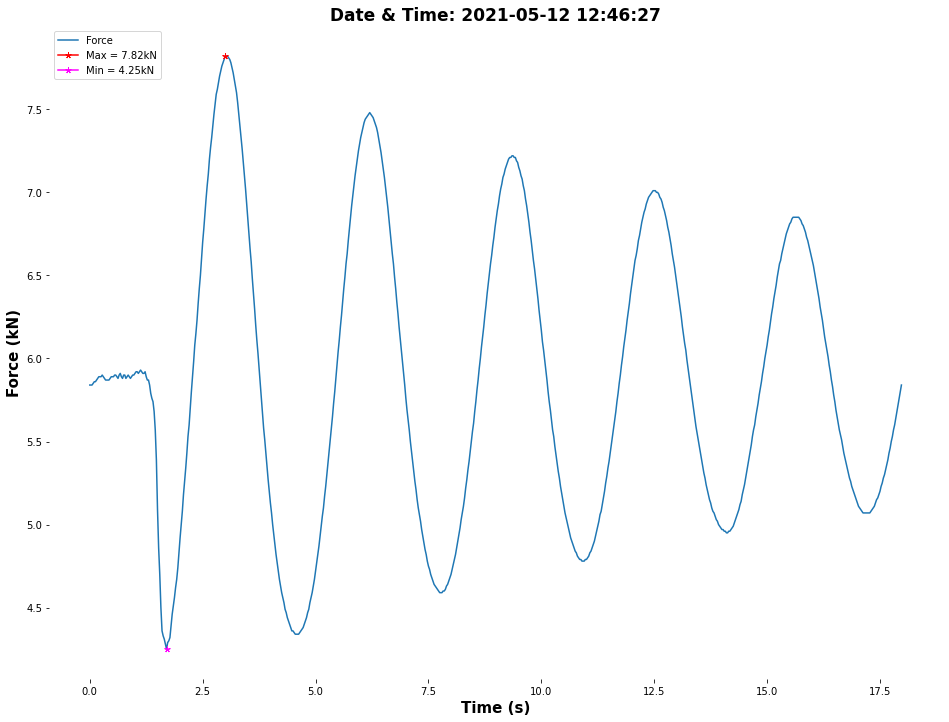

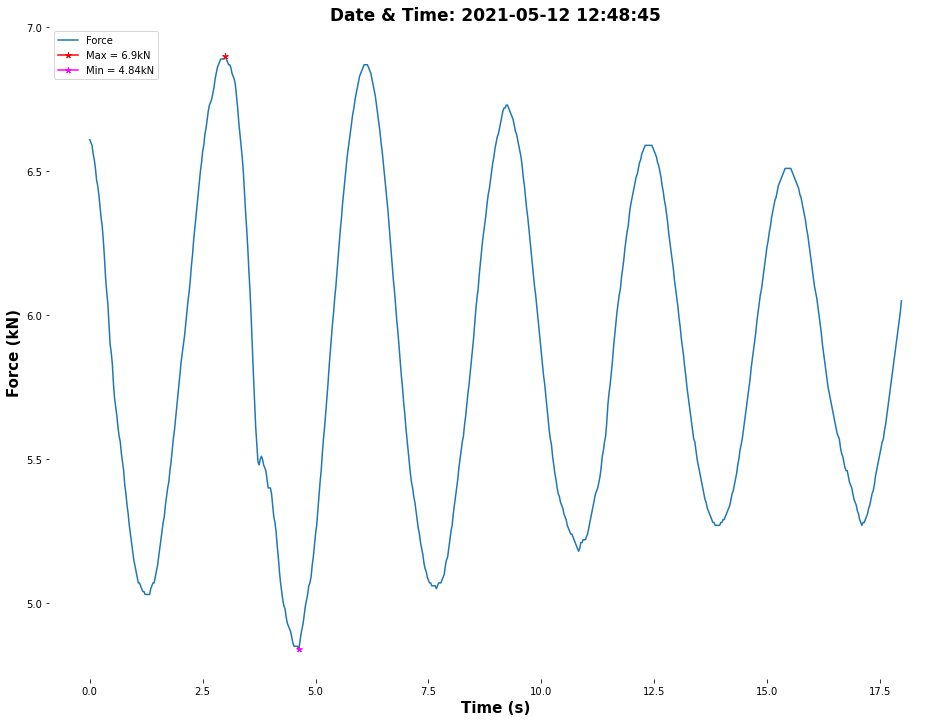

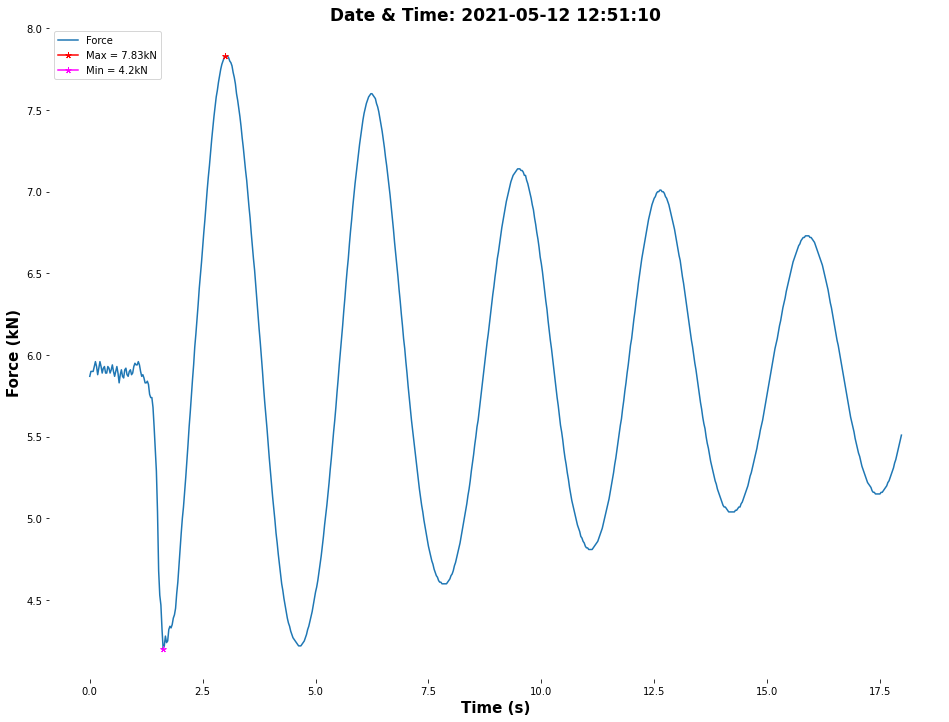

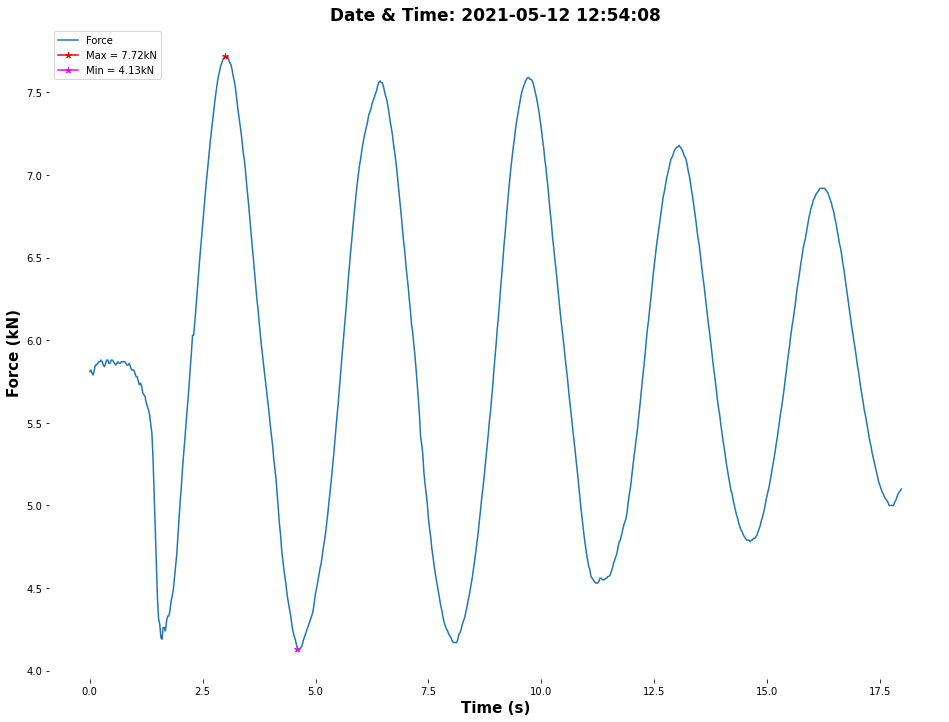

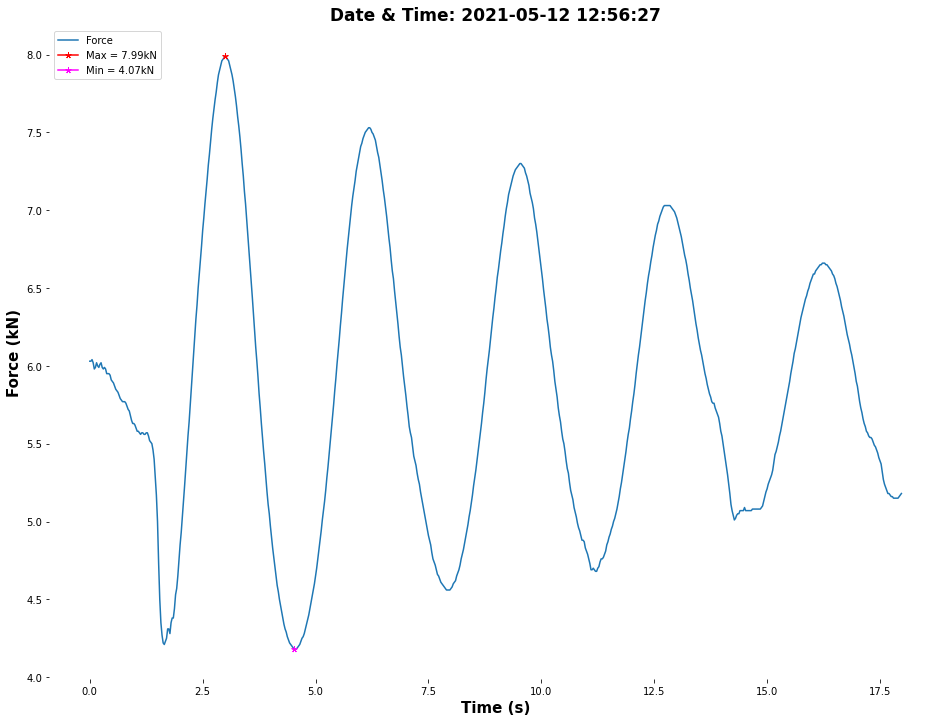

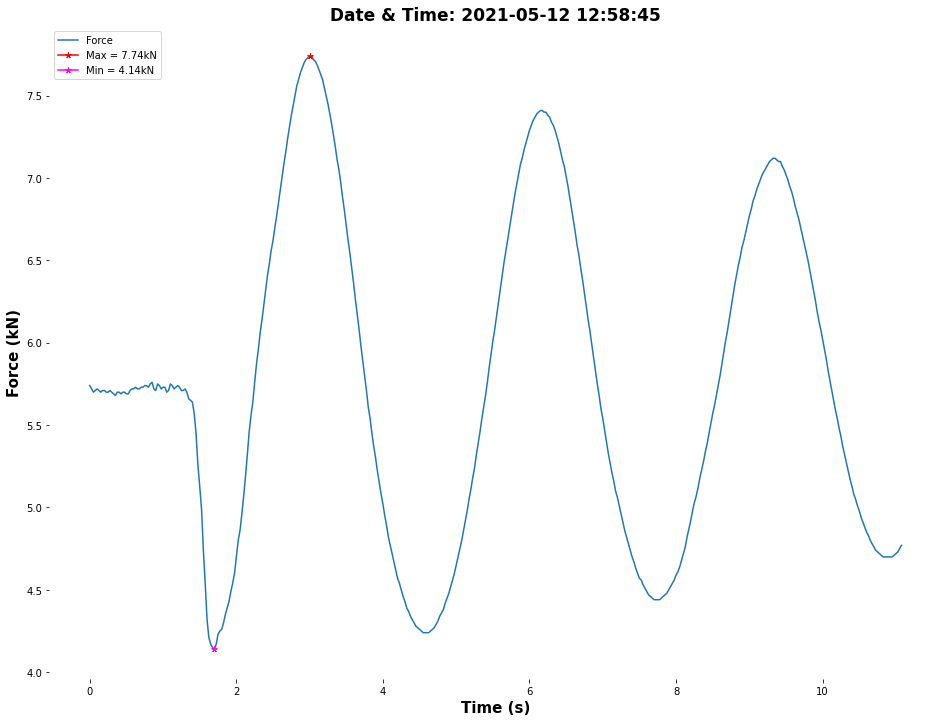

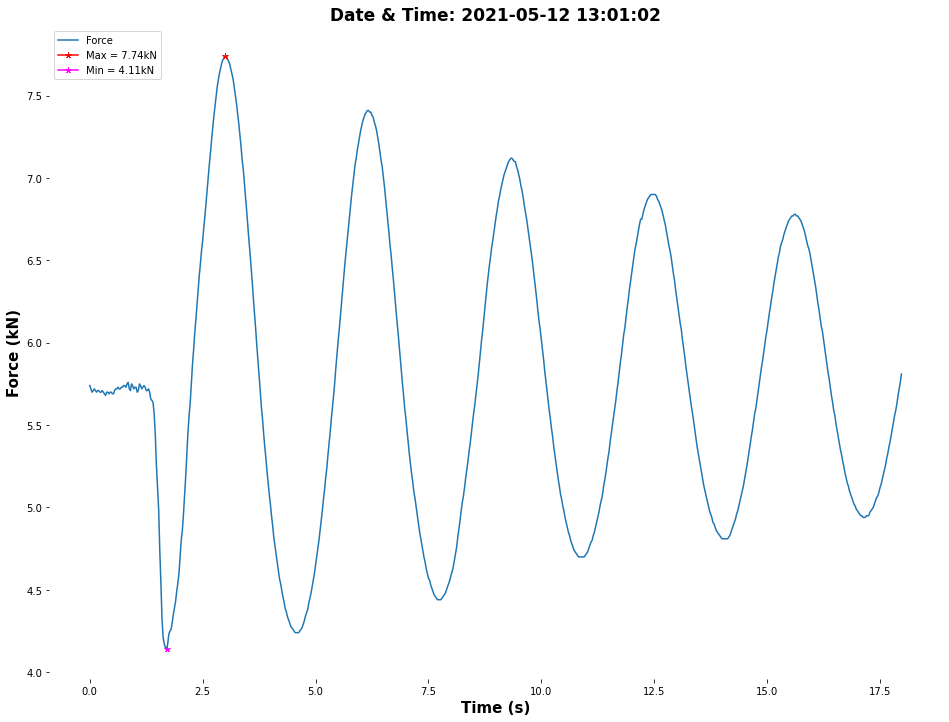

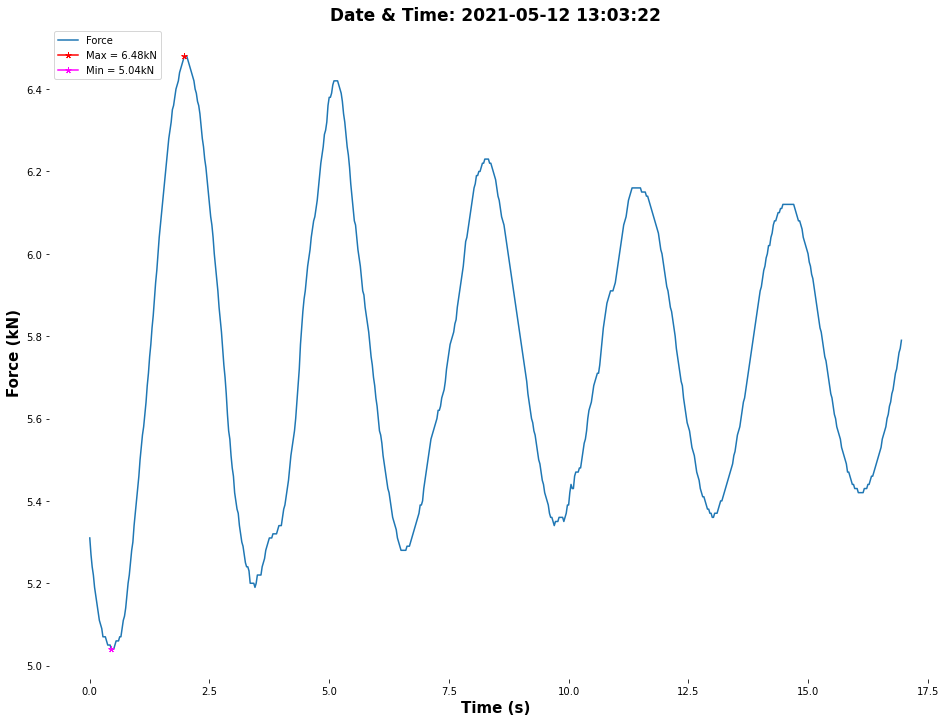

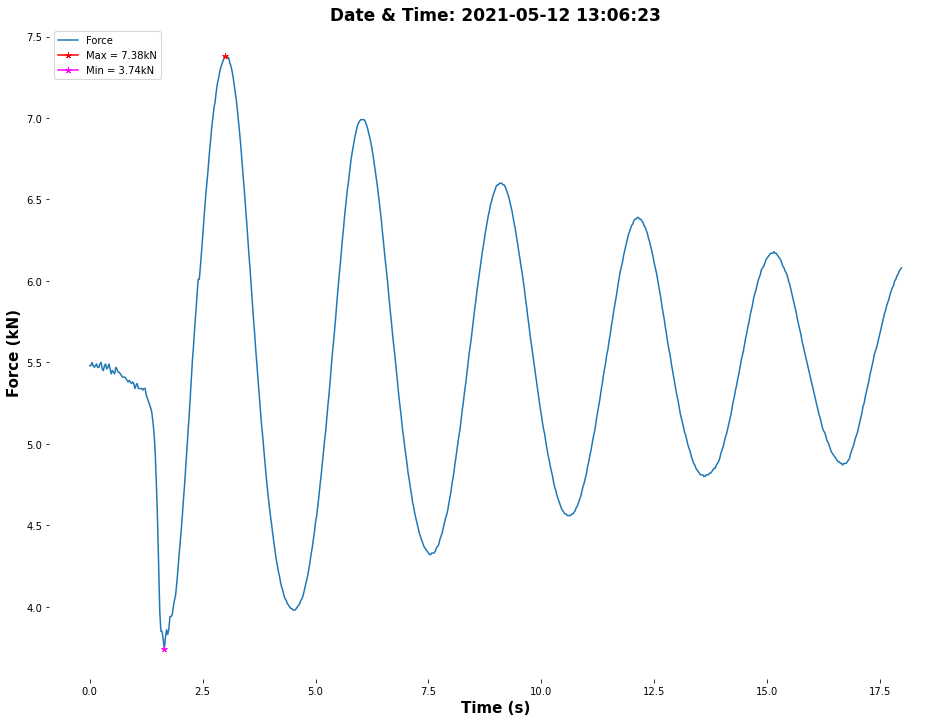

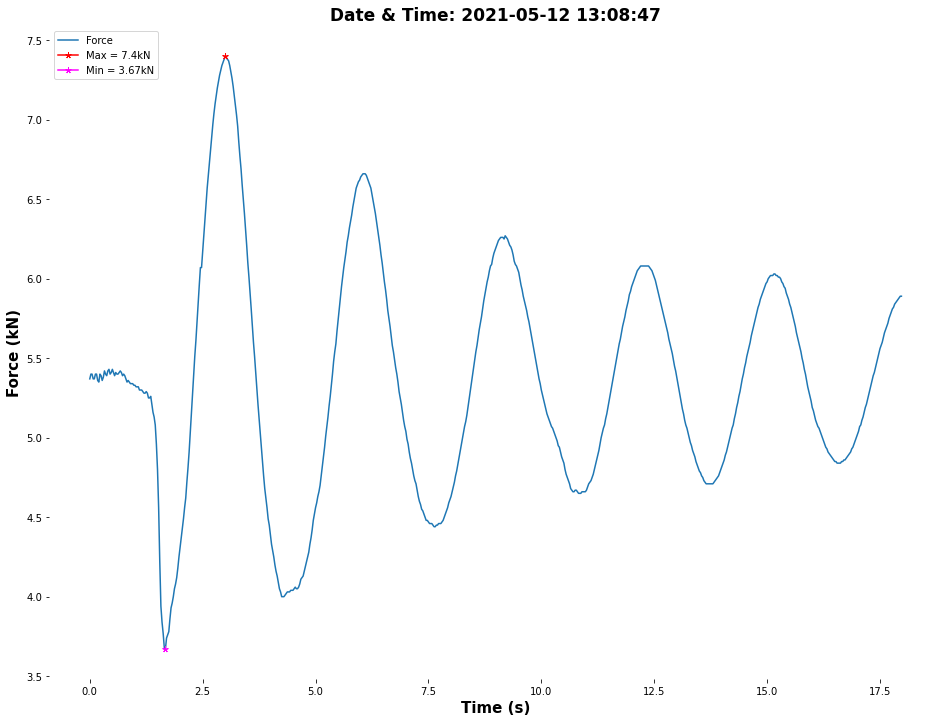

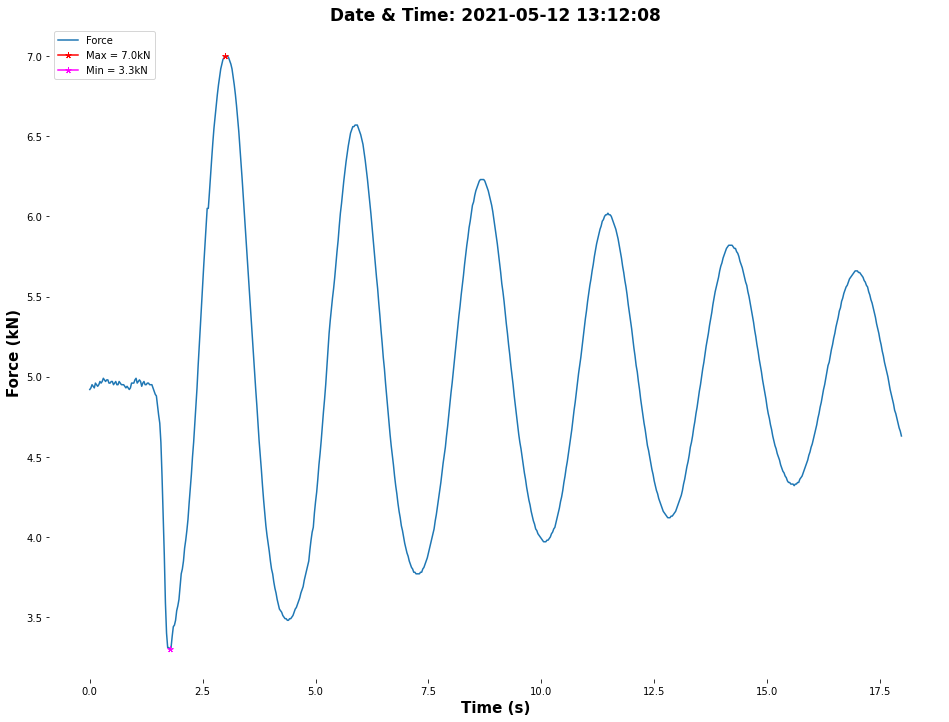

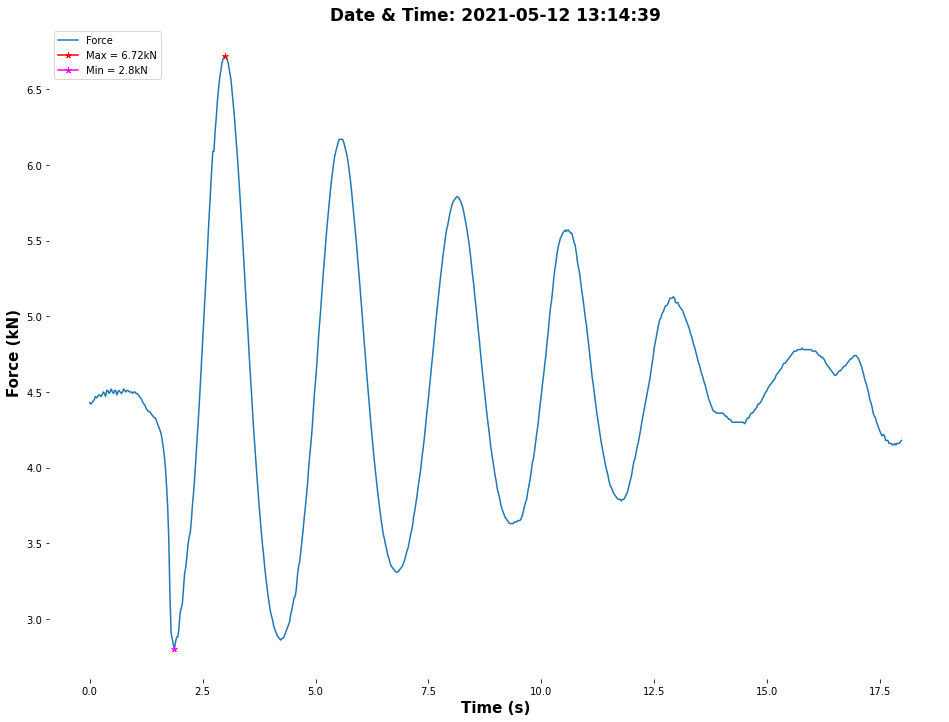

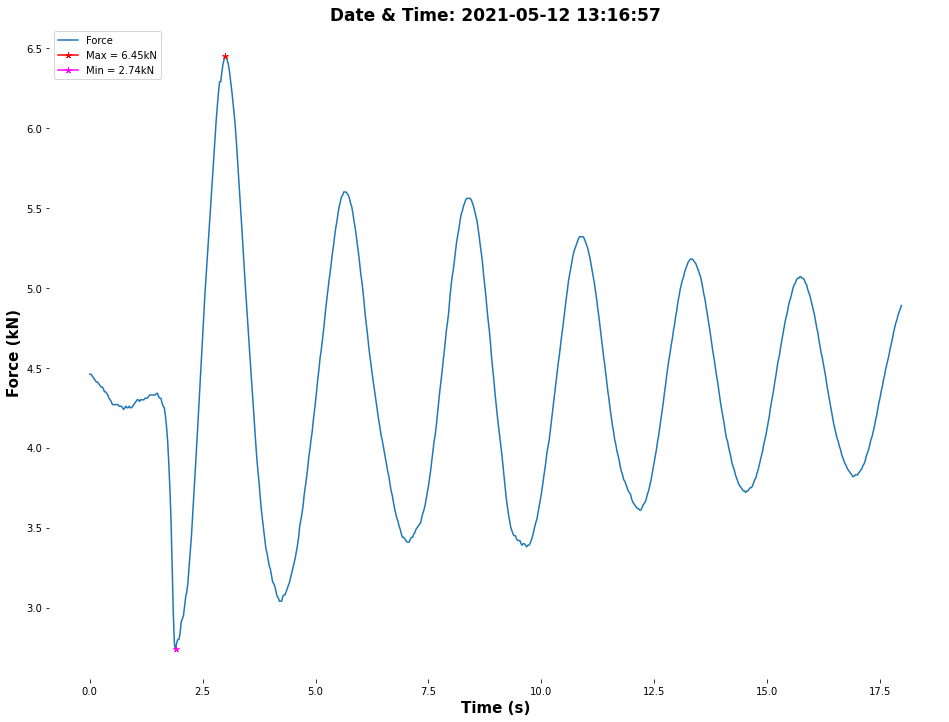

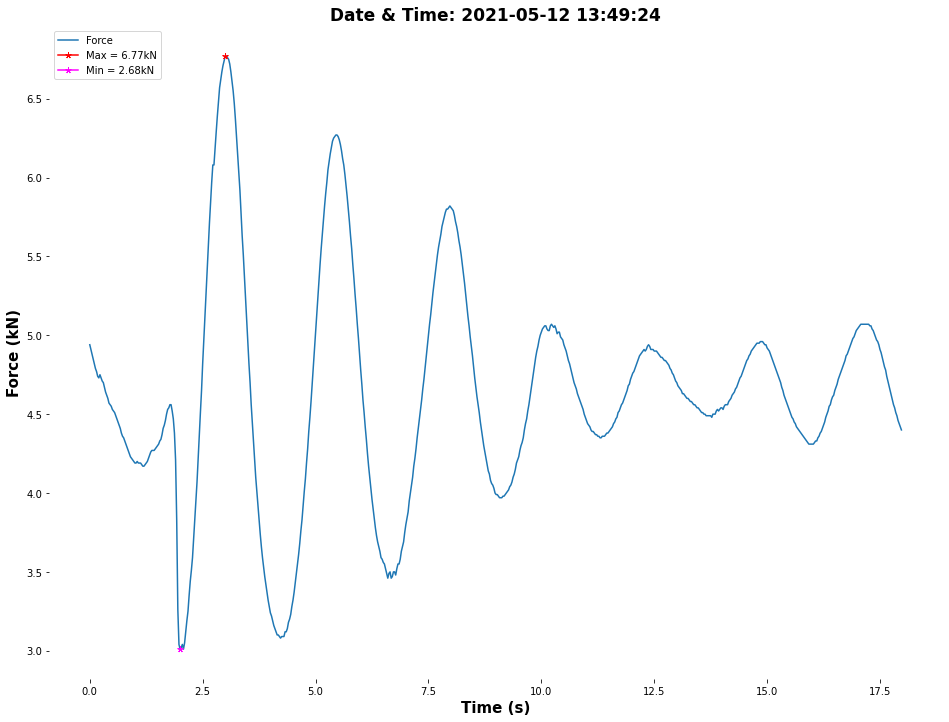

In [13]:
for i in df10.columns:
    plot_max_kN(df10, nums10, i)

for i in df40.columns:
    plot_max_kN(df40, nums40, i)
    
for i in df640.columns:
    plot_max_kN(df640, nums640, i)
    
for i in df1280.columns:
    plot_max_kN(df1280, nums1280, i)

In [14]:
# Write to excel file
with pd.ExcelWriter('Master.xlsx') as writer:
    df10.to_excel(writer, sheet_name = '10Hz Measurements')
    df40.to_excel(writer, sheet_name = '40Hz Measurements')
    df640.to_excel(writer, sheet_name = '640Hz Measurements')
    df1280.to_excel(writer, sheet_name = '1280Hz Measurements')